In [1]:
setwd('~/Downloads/proj/')

library(data.table)
library(edgeR)
library(EDASeq)
library(RUVSeq)
library(affycoretools)
library(ggplot2)
library(DESeq2)
library(pheatmap)
require(dplyr)
require(stringr)

# project directories, and libraries loaded and saving total number of patients

MM_cell_line = data.frame(fread("HMCL66_HTSeq_GENE_Counts_v2.txt"))
MM_patients = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))

num_pat_tot = length(MM_patients[2,])
num_cell_line_tot = length(MM_cell_line[2,])

# checking total number of patients and cell lines and output head

head(MM_cell_line)
head(MM_patients)
print(num_pat_tot)
print(num_cell_line_tot)

Loading required package: limma
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, tab

Sample          GENE_NAME ALMC1_DJ_p27 ALMC2_DJ_p11 AMO1_DSMZ_p8
1 ENSG00000000003 TSPAN6       2            0          100        
2 ENSG00000000005 TNMD         1            0            0        
3 ENSG00000000419 DPM1      3949         4134         4795        
4 ENSG00000000457 SCYL3     1597         1513         2412        
5 ENSG00000000460 C1orf112  3072         1488         2193        
6 ENSG00000000938 FGR          0           22          701        
  ANBL6_DJ2_p13 COLO677_DSMZ_p8 Delta47_JCRB_p16 DP6_DJ_p7 EJM_DSMZ_p9 ⋯
1    2             0               0                2        88        ⋯
2    0             1               0                0         0        ⋯
3 8278          2262            2587             3607      2450        ⋯
4 1988          1530             926             1415       573        ⋯
5 4091          3208            1170             3614      1618        ⋯
6    5             2               4               89         4        ⋯
  RPMI8226_ATCC_p7 SKMM1_p6 SKMM2_DSMZ_p17 U266_ATCC_p8 UTMC2_p6 VP6_DJ_p5
1    2                0        0              0            0        0     
2    0                1        0              0            0        0     
3 2694             1247     3263           3044         3108     4538     
4  665              994      497           1611         1603     1375     
5 1472             1517     1346           2068         3128     1850     
6    0              125      777             50         1890     2315     
  XG1_p5 XG2_p5 XG6_p5 XG7_p6
1    0      0      2     114 
2    0      0      0       0 
3 7336   4430   9279   13828 
4 1426    893   1540    1660 
5 2522   2320    793     689 
6 1514      5   3776     847

GENE_ID         MMRF_2801_1_BM MMRF_2718_1_BM MMRF_2815_1_BM MMRF_1656_1_BM
1 ENSG00000000003   17            999             85              9          
2 ENSG00000000005    1              0              0              2          
3 ENSG00000000419 1495           3271           2303           1234          
4 ENSG00000000457  231            809            203           1208          
5 ENSG00000000460   87            319             31            183          
6 ENSG00000000938  318            105            119            190          
  MMRF_2461_1_BM MMRF_2531_2_PB MMRF_2057_1_BM MMRF_1910_1_BM MMRF_2089_2_BM ⋯
1  801             20             12             16              4           ⋯
2    3              0              0              0              0           ⋯
3 1896           4400           2013           1745           1698           ⋯
4  425           2793            710            922            853           ⋯
5   85            929            174            292            837           ⋯
6 2064           2952             12            351            498           ⋯
  MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_1978_2_BM MMRF_2795_1_BM
1    2            186           102             347            128          
2    0              0             0               0              0          
3 2459           1269           337            3347           1049          
4  734            771           327             392             90          
5  267            104           114             126             17          
6   46             14           303            2007             58          
  MMRF_2316_1_BM MMRF_2606_2_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
1   17             11              3             18             6           
2    0              1              0              0             0           
3 2545           1625           1253           1905           683           
4  406            857            548            808           393           
5   67            196            141            199            55           
6   77           1037             11            174            22

[1] 893
[1] 68


In [2]:
# finding genes in common and creating character vector of Ensembl Gene IDs

ensembl_intersect = intersect(MM_cell_line$Sample, MM_patients$GENE_ID)

# assigning rownames as ensembl gene IDs so as to be able to parse by ensembl Gene IDs

rownames(MM_cell_line) = MM_cell_line$Sample
rownames(MM_patients) = MM_patients$GENE_ID

# removing gene ID and gene name columns 
# and saving them in a separate place 
# note only those available in MM_cell_line
# also filtering out genes in common
# and fusing them into a single dataframe
# and filtering for only newly diagnosed patients

ensembl_ids = MM_cell_line[,1]
MM_cell_line = MM_cell_line[, -1]
gene_names = MM_cell_line[,1]
gene_info = cbind(ensembl_ids, gene_names)

MM_cell_line = MM_cell_line[,-1]
MM_cell_line = MM_cell_line[ensembl_intersect, ]
MM_patients = MM_patients[ensembl_intersect, -1]

MM_patient_ids = data.frame(colnames(MM_patients))
MM_patients_new = filter(MM_patient_ids, str_extract(MM_patient_ids[,1], "_[0-9]_") == "_1_")
keepc = colnames(MM_patients) %in% MM_patients_new[,1]
MM_patients = MM_patients[,keepc]

MM_combined = cbind(MM_cell_line, MM_patients)

# checking output head to confirm removal

head(MM_cell_line)
head(MM_patients)
head(MM_combined)
head(gene_info)

# saving number of newly diagnosed patients and printing out percentage

num_new_pat = length(MM_patients[2,])
print(num_new_pat)
print((num_new_pat/num_pat_tot)*100)

ALMC1_DJ_p27 ALMC2_DJ_p11 AMO1_DSMZ_p8 ANBL6_DJ2_p13
ENSG00000000003    2            0          100            2         
ENSG00000000005    1            0            0            0         
ENSG00000000419 3949         4134         4795         8278         
ENSG00000000457 1597         1513         2412         1988         
ENSG00000000460 3072         1488         2193         4091         
ENSG00000000938    0           22          701            5         
                COLO677_DSMZ_p8 Delta47_JCRB_p16 DP6_DJ_p7 EJM_DSMZ_p9
ENSG00000000003    0               0                2        88       
ENSG00000000005    1               0                0         0       
ENSG00000000419 2262            2587             3607      2450       
ENSG00000000457 1530             926             1415       573       
ENSG00000000460 3208            1170             3614      1618       
ENSG00000000938    2               4               89         4       
                FLAM76_JCRB_p10 FR4_p6 ⋯ RPMI8226_ATCC_p7 SKMM1_p6
ENSG00000000003    4               0   ⋯    2                0    
ENSG00000000005    0               0   ⋯    0                1    
ENSG00000000419 1388            3308   ⋯ 2694             1247    
ENSG00000000457 1013            1232   ⋯  665              994    
ENSG00000000460 1507            1491   ⋯ 1472             1517    
ENSG00000000938    2            2271   ⋯    0              125    
                SKMM2_DSMZ_p17 U266_ATCC_p8 UTMC2_p6 VP6_DJ_p5 XG1_p5 XG2_p5
ENSG00000000003    0              0            0        0         0      0  
ENSG00000000005    0              0            0        0         0      0  
ENSG00000000419 3263           3044         3108     4538      7336   4430  
ENSG00000000457  497           1611         1603     1375      1426    893  
ENSG00000000460 1346           2068         3128     1850      2522   2320  
ENSG00000000938  777             50         1890     2315      1514      5  
                XG6_p5 XG7_p6
ENSG00000000003    2     114 
ENSG00000000005    0       0 
ENSG00000000419 9279   13828 
ENSG00000000457 1540    1660 
ENSG00000000460  793     689 
ENSG00000000938 3776     847

MMRF_2801_1_BM MMRF_2718_1_BM MMRF_2815_1_BM MMRF_1656_1_BM
ENSG00000000003   17            999             85              9          
ENSG00000000005    1              0              0              2          
ENSG00000000419 1495           3271           2303           1234          
ENSG00000000457  231            809            203           1208          
ENSG00000000460   87            319             31            183          
ENSG00000000938  318            105            119            190          
                MMRF_2461_1_BM MMRF_2057_1_BM MMRF_1910_1_BM MMRF_2341_1_BM
ENSG00000000003  801             12             16             43          
ENSG00000000005    3              0              0              1          
ENSG00000000419 1896           2013           1745           2403          
ENSG00000000457  425            710            922           1203          
ENSG00000000460   85            174            292            478          
ENSG00000000938 2064             12            351            555          
                MMRF_2501_1_BM MMRF_1383_1_BM ⋯ MMRF_1731_1_BM MMRF_2799_1_BM
ENSG00000000003  594           693            ⋯    1             49          
ENSG00000000005    0             0            ⋯    0              0          
ENSG00000000419 1847           973            ⋯ 1751           2537          
ENSG00000000457 1160           587            ⋯  493            220          
ENSG00000000460  218           107            ⋯  104             50          
ENSG00000000938   37            21            ⋯ 3064             46          
                MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_2795_1_BM
ENSG00000000003    2            186           102             128          
ENSG00000000005    0              0             0               0          
ENSG00000000419 2459           1269           337            1049          
ENSG00000000457  734            771           327              90          
ENSG00000000460  267            104           114              17          
ENSG00000000938   46             14           303              58          
                MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
ENSG00000000003   17              3             18             6           
ENSG00000000005    0              0              0             0           
ENSG00000000419 2545           1253           1905           683           
ENSG00000000457  406            548            808           393           
ENSG00000000460   67            141            199            55           
ENSG00000000938   77             11            174            22

ALMC1_DJ_p27 ALMC2_DJ_p11 AMO1_DSMZ_p8 ANBL6_DJ2_p13
ENSG00000000003    2            0          100            2         
ENSG00000000005    1            0            0            0         
ENSG00000000419 3949         4134         4795         8278         
ENSG00000000457 1597         1513         2412         1988         
ENSG00000000460 3072         1488         2193         4091         
ENSG00000000938    0           22          701            5         
                COLO677_DSMZ_p8 Delta47_JCRB_p16 DP6_DJ_p7 EJM_DSMZ_p9
ENSG00000000003    0               0                2        88       
ENSG00000000005    1               0                0         0       
ENSG00000000419 2262            2587             3607      2450       
ENSG00000000457 1530             926             1415       573       
ENSG00000000460 3208            1170             3614      1618       
ENSG00000000938    2               4               89         4       
                FLAM76_JCRB_p10 FR4_p6 ⋯ MMRF_1731_1_BM MMRF_2799_1_BM
ENSG00000000003    4               0   ⋯    1             49          
ENSG00000000005    0               0   ⋯    0              0          
ENSG00000000419 1388            3308   ⋯ 1751           2537          
ENSG00000000457 1013            1232   ⋯  493            220          
ENSG00000000460 1507            1491   ⋯  104             50          
ENSG00000000938    2            2271   ⋯ 3064             46          
                MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_2795_1_BM
ENSG00000000003    2            186           102             128          
ENSG00000000005    0              0             0               0          
ENSG00000000419 2459           1269           337            1049          
ENSG00000000457  734            771           327              90          
ENSG00000000460  267            104           114              17          
ENSG00000000938   46             14           303              58          
                MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
ENSG00000000003   17              3             18             6           
ENSG00000000005    0              0              0             0           
ENSG00000000419 2545           1253           1905           683           
ENSG00000000457  406            548            808           393           
ENSG00000000460   67            141            199            55           
ENSG00000000938   77             11            174            22

ensembl_ids     gene_names
[1,] ENSG00000000003 TSPAN6    
[2,] ENSG00000000005 TNMD      
[3,] ENSG00000000419 DPM1      
[4,] ENSG00000000457 SCYL3     
[5,] ENSG00000000460 C1orf112  
[6,] ENSG00000000938 FGR

[1] 779
[1] 87.23404


In [3]:
# transforming counts of cell_line, patients, and combined 
# to account for sequencing depth
# and creating boolean vector of those genes that
# holds TRUE for genes that account for greater than a millionth
# of total mapped reads in 2 or more samples
# then filtering MM_combined based on this vector
# aka filtering out low count genes


MM_combined_cpm = cpm(MM_combined)
keep = rowSums(MM_combined_cpm > 1) > 2
MM_combined.filtered = MM_combined[keep, ]
MM_patients = MM_patients[keep, ]
MM_cell_line = MM_cell_line[keep, ]

# checking output head

head(keep)
head(MM_combined.filtered)

ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
           TRUE           FALSE            TRUE            TRUE            TRUE 
ENSG00000000938 
           TRUE

ALMC1_DJ_p27 ALMC2_DJ_p11 AMO1_DSMZ_p8 ANBL6_DJ2_p13
ENSG00000000003    2            0          100            2         
ENSG00000000419 3949         4134         4795         8278         
ENSG00000000457 1597         1513         2412         1988         
ENSG00000000460 3072         1488         2193         4091         
ENSG00000000938    0           22          701            5         
ENSG00000000971   11          207           24           21         
                COLO677_DSMZ_p8 Delta47_JCRB_p16 DP6_DJ_p7 EJM_DSMZ_p9
ENSG00000000003    0               0                2        88       
ENSG00000000419 2262            2587             3607      2450       
ENSG00000000457 1530             926             1415       573       
ENSG00000000460 3208            1170             3614      1618       
ENSG00000000938    2               4               89         4       
ENSG00000000971   18               8              685        12       
                FLAM76_JCRB_p10 FR4_p6 ⋯ MMRF_1731_1_BM MMRF_2799_1_BM
ENSG00000000003    4               0   ⋯    1             49          
ENSG00000000419 1388            3308   ⋯ 1751           2537          
ENSG00000000457 1013            1232   ⋯  493            220          
ENSG00000000460 1507            1491   ⋯  104             50          
ENSG00000000938    2            2271   ⋯ 3064             46          
ENSG00000000971   28               2   ⋯ 2566             27          
                MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_2795_1_BM
ENSG00000000003    2            186           102             128          
ENSG00000000419 2459           1269           337            1049          
ENSG00000000457  734            771           327              90          
ENSG00000000460  267            104           114              17          
ENSG00000000938   46             14           303              58          
ENSG00000000971   13              5            28              30          
                MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
ENSG00000000003   17              3             18             6           
ENSG00000000419 2545           1253           1905           683           
ENSG00000000457  406            548            808           393           
ENSG00000000460   67            141            199            55           
ENSG00000000938   77             11            174            22           
ENSG00000000971   18           1680             56            10

In [4]:
# transforming counts of cell_line, patients, and combined 
# to account for sequencing depth
# and creating boolean vector of those genes that
# holds TRUE for genes that account for greater than a millionth
# of total mapped reads in 2 or more samples
# then filtering MM_combined based on this vector
# aka filtering out low count genes


MM_combined_cpm = cpm(MM_combined)
keep = rowSums(MM_combined_cpm > 1) > 2
MM_combined.filtered = MM_combined[keep, ]
MM_patients = MM_patients[keep, ]
MM_cell_line = MM_cell_line[keep, ]

# checking output head

head(keep)
head(MM_combined.filtered)

ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
           TRUE           FALSE            TRUE            TRUE            TRUE 
ENSG00000000938 
           TRUE

ALMC1_DJ_p27 ALMC2_DJ_p11 AMO1_DSMZ_p8 ANBL6_DJ2_p13
ENSG00000000003    2            0          100            2         
ENSG00000000419 3949         4134         4795         8278         
ENSG00000000457 1597         1513         2412         1988         
ENSG00000000460 3072         1488         2193         4091         
ENSG00000000938    0           22          701            5         
ENSG00000000971   11          207           24           21         
                COLO677_DSMZ_p8 Delta47_JCRB_p16 DP6_DJ_p7 EJM_DSMZ_p9
ENSG00000000003    0               0                2        88       
ENSG00000000419 2262            2587             3607      2450       
ENSG00000000457 1530             926             1415       573       
ENSG00000000460 3208            1170             3614      1618       
ENSG00000000938    2               4               89         4       
ENSG00000000971   18               8              685        12       
                FLAM76_JCRB_p10 FR4_p6 ⋯ MMRF_1731_1_BM MMRF_2799_1_BM
ENSG00000000003    4               0   ⋯    1             49          
ENSG00000000419 1388            3308   ⋯ 1751           2537          
ENSG00000000457 1013            1232   ⋯  493            220          
ENSG00000000460 1507            1491   ⋯  104             50          
ENSG00000000938    2            2271   ⋯ 3064             46          
ENSG00000000971   28               2   ⋯ 2566             27          
                MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_2795_1_BM
ENSG00000000003    2            186           102             128          
ENSG00000000419 2459           1269           337            1049          
ENSG00000000457  734            771           327              90          
ENSG00000000460  267            104           114              17          
ENSG00000000938   46             14           303              58          
ENSG00000000971   13              5            28              30          
                MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
ENSG00000000003   17              3             18             6           
ENSG00000000419 2545           1253           1905           683           
ENSG00000000457  406            548            808           393           
ENSG00000000460   67            141            199            55           
ENSG00000000938   77             11            174            22           
ENSG00000000971   18           1680             56            10

In [5]:
# normalizing combined data frame with vst

norm_combined = vst(as.matrix(MM_combined.filtered))

# checking output head

head(norm_combined)

ALMC1_DJ_p27 ALMC2_DJ_p11 AMO1_DSMZ_p8 ANBL6_DJ2_p13
ENSG00000000003  5.121115     4.830701     6.753159     5.087762    
ENSG00000000419 11.192958    11.058860    11.481792    11.894072    
ENSG00000000457  9.936576     9.672406    10.518177     9.901600    
ENSG00000000460 10.840491     9.650001    10.386322    10.898915    
ENSG00000000938  4.830701     5.715836     8.861104     5.236351    
ENSG00000000971  5.506729     7.282633     5.824017     5.653577    
                COLO677_DSMZ_p8 Delta47_JCRB_p16 DP6_DJ_p7 EJM_DSMZ_p9
ENSG00000000003  4.830701        4.830701         5.122115  6.930293  
ENSG00000000419 10.306507       10.979705        11.075250 11.003090  
ENSG00000000457  9.772317        9.566903         9.781765  9.028327  
ENSG00000000460 10.791701        9.882322        11.077974 10.424602  
ENSG00000000938  5.110011        5.299783         6.654161  5.316598  
ENSG00000000971  5.658535        5.491225         8.827028  5.664625  
                FLAM76_JCRB_p10 FR4_p6    ⋯ MMRF_1731_1_BM MMRF_2799_1_BM
ENSG00000000003  5.303622        4.830701 ⋯  5.131689       6.907446     
ENSG00000000419 10.138017       11.723434 ⋯ 11.124923      11.843401     
ENSG00000000457  9.709607       10.338227 ⋯  9.384906       8.525344     
ENSG00000000460 10.251060       10.602664 ⋯  7.505744       6.925478     
ENSG00000000938  5.165852       11.191736 ⋯ 11.916476       6.851781     
ENSG00000000971  6.050852        5.213020 ⋯ 11.664665       6.426298     
                MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_2795_1_BM
ENSG00000000003  5.196712       7.948939      7.400009        8.320791     
ENSG00000000419 11.180281      10.426509      8.784326       11.123679     
ENSG00000000457  9.514931       9.744664      8.746203        7.907656     
ENSG00000000460  8.229035       7.322156      7.515750        6.363182     
ENSG00000000938  6.496629       5.841891      8.650335        7.430139     
ENSG00000000971  5.750688       5.442846      6.297891        6.805684     
                MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
ENSG00000000003  6.082664       5.345835       5.900425       5.872658     
ENSG00000000419 11.761265      10.632905      10.805345      10.830429     
ENSG00000000457  9.229529       9.503027       9.627453      10.065296     
ENSG00000000460  7.140238       7.818035       7.873429       7.606155     
ENSG00000000938  7.276126       5.803804       7.723670       6.729497     
ENSG00000000971  6.116758      11.042982       6.640096       6.157982

In [6]:
# separating out patient and cell line columns from norm_combined 

norm_pat = norm_combined[,colnames(MM_patients)]#pat_bool]
norm_cell = norm_combined[,colnames(MM_cell_line)]

# checking output head

head(norm_pat)
head(norm_cell)

MMRF_2801_1_BM MMRF_2718_1_BM MMRF_2815_1_BM MMRF_1656_1_BM
ENSG00000000003  6.060798       9.545865       7.504912       5.678664     
ENSG00000000419 10.957643      11.180638      11.796341      10.495380     
ENSG00000000457  8.464263       9.266066       8.504619      10.465857     
ENSG00000000460  7.361361       8.102342       6.578214       8.019636     
ENSG00000000938  8.864747       6.942817       7.872284       8.063233     
ENSG00000000971  8.976686       9.666459       9.285435       7.717287     
                MMRF_2461_1_BM MMRF_2057_1_BM MMRF_1910_1_BM MMRF_2341_1_BM
ENSG00000000003  9.831334       5.882917       5.839145       6.162487     
ENSG00000000419 11.022594      11.404325      10.675590      10.560857     
ENSG00000000457  8.991437       9.954385       9.798282       9.614478     
ENSG00000000460  7.149116       8.146953       8.315703       8.425506     
ENSG00000000938 11.141904       5.882917       8.540640       8.609911     
ENSG00000000971  8.495919       6.037327       8.073008       6.039664     
                MMRF_2501_1_BM MMRF_1383_1_BM ⋯ MMRF_1731_1_BM MMRF_2799_1_BM
ENSG00000000003  9.012450      10.080853      ⋯  5.131689       6.907446     
ENSG00000000419 10.541196      10.548945      ⋯ 11.124923      11.843401     
ENSG00000000457  9.901645       9.854608      ⋯  9.384906       8.525344     
ENSG00000000460  7.797638       7.725440      ⋯  7.505744       6.925478     
ENSG00000000938  6.225164       6.277881      ⋯ 11.916476       6.851781     
ENSG00000000971  6.582150       6.067497      ⋯ 11.664665       6.426298     
                MMRF_2379_1_BM MMRF_1474_1_BM MMRF_1641_1_BM MMRF_2795_1_BM
ENSG00000000003  5.196712       7.948939      7.400009        8.320791     
ENSG00000000419 11.180281      10.426509      8.784326       11.123679     
ENSG00000000457  9.514931       9.744664      8.746203        7.907656     
ENSG00000000460  8.229035       7.322156      7.515750        6.363182     
ENSG00000000938  6.496629       5.841891      8.650335        7.430139     
ENSG00000000971  5.750688       5.442846      6.297891        6.805684     
                MMRF_2316_1_BM MMRF_2440_1_BM MMRF_2731_1_BM MMRF_1355_1_BM
ENSG00000000003  6.082664       5.345835       5.900425       5.872658     
ENSG00000000419 11.761265      10.632905      10.805345      10.830429     
ENSG00000000457  9.229529       9.503027       9.627453      10.065296     
ENSG00000000460  7.140238       7.818035       7.873429       7.606155     
ENSG00000000938  7.276126       5.803804       7.723670       6.729497     
ENSG00000000971  6.116758      11.042982       6.640096       6.157982

ALMC1_DJ_p27 ALMC2_DJ_p11 AMO1_DSMZ_p8 ANBL6_DJ2_p13
ENSG00000000003  5.121115     4.830701     6.753159     5.087762    
ENSG00000000419 11.192958    11.058860    11.481792    11.894072    
ENSG00000000457  9.936576     9.672406    10.518177     9.901600    
ENSG00000000460 10.840491     9.650001    10.386322    10.898915    
ENSG00000000938  4.830701     5.715836     8.861104     5.236351    
ENSG00000000971  5.506729     7.282633     5.824017     5.653577    
                COLO677_DSMZ_p8 Delta47_JCRB_p16 DP6_DJ_p7 EJM_DSMZ_p9
ENSG00000000003  4.830701        4.830701         5.122115  6.930293  
ENSG00000000419 10.306507       10.979705        11.075250 11.003090  
ENSG00000000457  9.772317        9.566903         9.781765  9.028327  
ENSG00000000460 10.791701        9.882322        11.077974 10.424602  
ENSG00000000938  5.110011        5.299783         6.654161  5.316598  
ENSG00000000971  5.658535        5.491225         8.827028  5.664625  
                FLAM76_JCRB_p10 FR4_p6    ⋯ RPMI8226_ATCC_p7 SKMM1_p6 
ENSG00000000003  5.303622        4.830701 ⋯  5.183315         4.830701
ENSG00000000419 10.138017       11.723434 ⋯ 11.203237        10.090880
ENSG00000000457  9.709607       10.338227 ⋯  9.284631         9.782236
ENSG00000000460 10.251060       10.602664 ⋯ 10.359418        10.360492
ENSG00000000938  5.165852       11.191736 ⋯  4.830701         7.279769
ENSG00000000971  6.050852        5.213020 ⋯  7.226316         5.705353
                SKMM2_DSMZ_p17 U266_ATCC_p8 UTMC2_p6  VP6_DJ_p5 XG1_p5   
ENSG00000000003  4.830701       4.830701     4.830701  4.830701  4.830701
ENSG00000000419 11.337907      10.916534    10.580120 11.126976 11.934854
ENSG00000000457  8.783722      10.035066     9.673136  9.484374  9.654509
ENSG00000000460 10.104075      10.378362    10.589037  9.883744 10.433379
ENSG00000000938  9.363245       6.271504     9.895878 10.190136  9.735164
ENSG00000000971  6.555933       5.130448     7.075538  5.971329  6.803862
                XG2_p5    XG6_p5    XG7_p6   
ENSG00000000003  4.830701  5.118442  6.661173
ENSG00000000419 11.032084 12.378849 12.643881
ENSG00000000457  8.863879  9.861965  9.674925
ENSG00000000460 10.133464  8.981951  8.534477
ENSG00000000938  5.239458 11.103832  8.793222
ENSG00000000971  8.441138  7.936526  7.174217

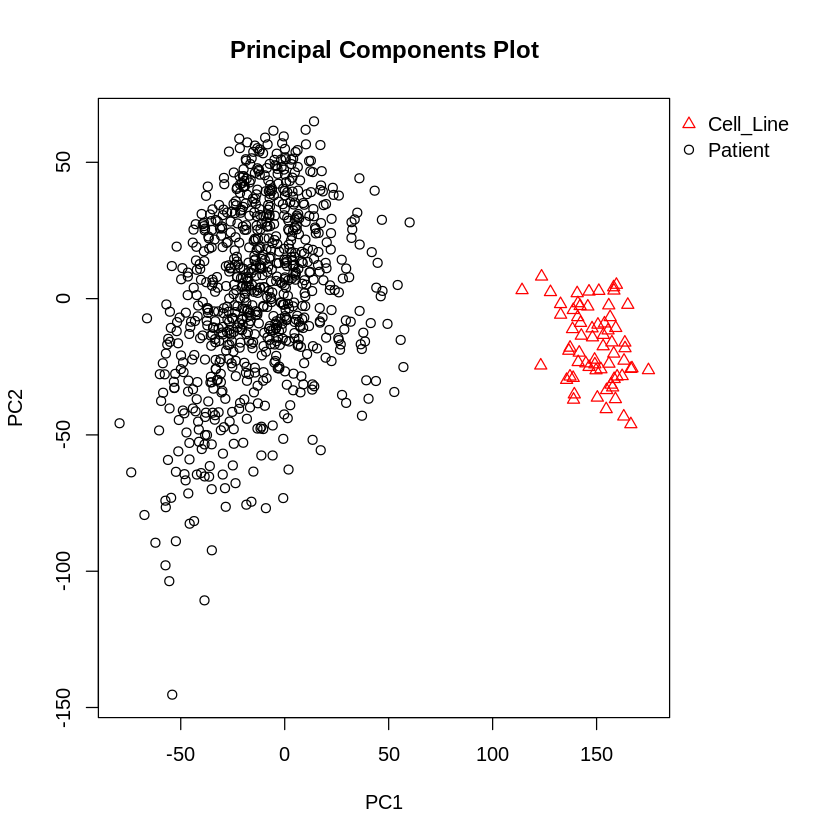

In [7]:
# using PCA to ensure populations are still distinct prior to analysis

symbols = c(rep(2, ncol(MM_cell_line)), rep(1, ncol(MM_patients)))
affycoretools::plotPCA(norm_combined, groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

In [8]:
# utilizing IQR to get vector of top 5000 and top 10000 genes

keepi = apply(norm_pat, 1, IQR)
keepis = sort(keepi, decreasing = TRUE)
keepi5000 = keepi %in% keepis[1:5000]
keepi10000 = keepi %in% keepis[1:10000]

In [9]:
# making function for doing correlation analysis and generating violin plots

makeplots = function(corset, pnames, clnames, titl) {
    
    MM.cor.v = cor(corset, method = "s")

    #clnames = colnames(MM_cell_line)
    tumor_cell_all = data.frame()

    for(patients in pnames){
        cell_line_tumor_cor = MM.cor.v[patients, clnames]
        cell_line_tumor_cor = data.frame(patient = patients, 
                                         sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
        tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
    }

    cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
    cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
    tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

      p <- ggplot(tumor_cell_all, aes(sample, cor))
      print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + 
              xlab("") + labs(title = titl) +
              stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", 
                           fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  
            theme(panel.background = element_rect(color = 'white'), 
                  axis.text.x = element_text(angle = 70, hjust = 1, size=8)) 
      )
   # return(cell_line_order)
}

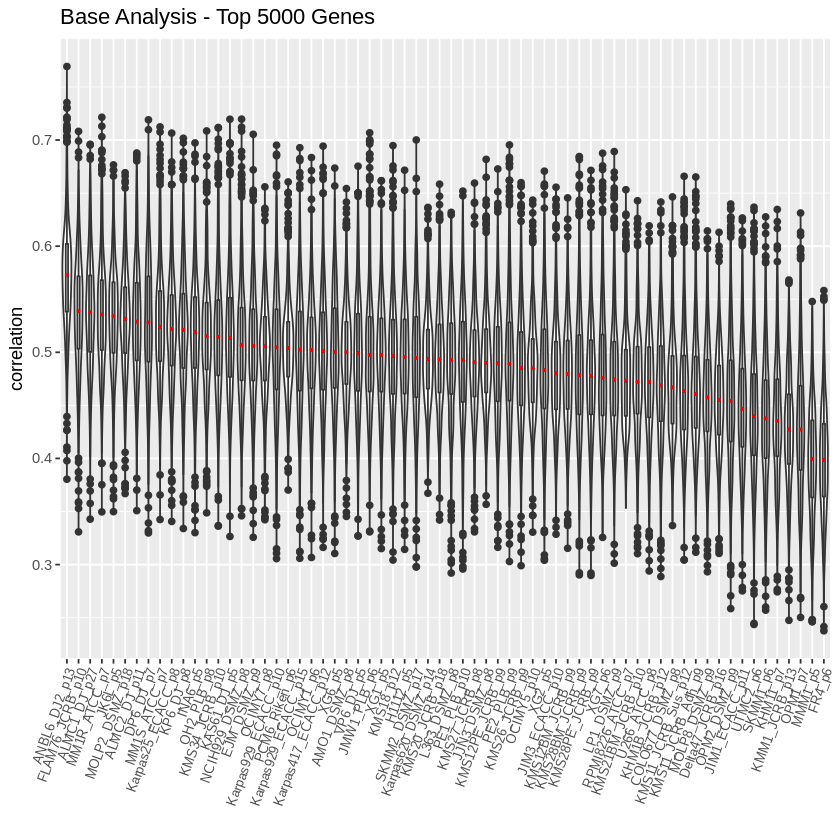

In [10]:
# plots for main analysis using all genes

#makeplots(norm_combined, colnames(MM_patients), 'Base Analysis - All Genes')

# subsetting top 5000 / 10000 genes

norm_combined_5000 = norm_combined[keepi5000, ]
#norm_combined_10000 = norm_combined[keepi10000, ]

# plots for main analysis using top 5000 / 10000 genes
MM.cor.keats = cor(norm_combined_5000, method = "s")
makeplots(norm_combined_5000, colnames(MM_patients), colnames(MM_cell_line), 'Base Analysis - Top 5000 Genes')
#makeplots(norm_combined_10000, colnames(MM_patients), 'Base Analysis - Top 10000 Genes')

In [11]:
#### DATA FOR TRANSLOCATIONS ####

MM_patients_trans = data.frame(fread("IA13a.structural.variants.annot.translocations.clean.maxHom0.8.minMap0.2.clonality.readRange10000bp.cnvRange2000bp.common.txt"))
MM_patient_trans_ids = MM_patients_trans[,'sample']

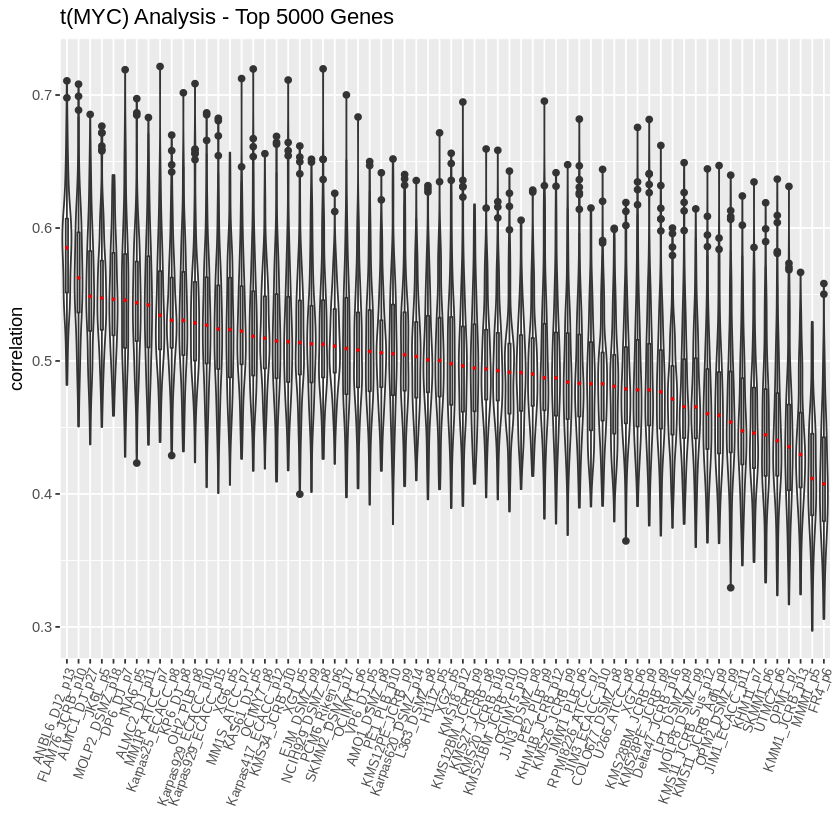

In [12]:
# extracting patients with MYC translocation who are also newly diagnosed

keepMYC = as.logical(MM_patients_trans[,'t.MYC.'])
MM_patients_trans_MYC = MM_patient_trans_ids[keepMYC]
MM_patients_trans_MYC = unique(MM_patients_trans_MYC)
MM_patients_new_trans_MYC = filter(as.data.frame(MM_patients_trans_MYC),
                                   str_extract(as.data.frame(MM_patients_trans_MYC)[,1], "_[0-9]_") == "_1_")
keepcMYC = colnames(MM_patients) %in% MM_patients_new_trans_MYC[,1]

# subsetting norm_pat to those patients with translocation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_MYC = norm_pat[,keepcMYC]
norm_combined_MYC = cbind(norm_cell, norm_pat_MYC)
norm_combined_MYC_5000 = norm_combined_MYC[keepi5000, ]
# norm_combined_MYC_10000 = norm_combined_MYC[keepi10000, ]

# plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_MYC, colnames(norm_pat_MYC), 't(MYC) Analysis - All Genes')
makeplots(norm_combined_MYC_5000, colnames(norm_pat_MYC), colnames(MM_cell_line), 't(MYC) Analysis - Top 5000 Genes')
# makeplots(norm_combined_MYC_10000, colnames(norm_pat_MYC), 't(MYC) Analysis - Top 10000 Genes')

# determining top 5000 / 10000 genes from only patients that have MYC transloation

keepi_tMYC = apply(norm_pat_MYC, 1, IQR)
keepis_tMYC = sort(keepi_tMYC, decreasing = TRUE)
keepi_tMYC_5000 = keepi_tMYC %in% keepis_tMYC[1:5000]
# keepi_tMYC_10000 = keepi_tMYC %in% keepis_tMYC[1:10000]

# subsetting norm_pat to keep newly filtered genes

norm_combined_MYC_u_5000 = norm_combined_MYC[keepi_tMYC_5000, ]
# norm_combined_MYC_u_10000 = norm_combined_MYC[keepi_tMYC_10000, ]

# plots using newly filtered genes

# makeplots(norm_combined_MYC_u_5000, colnames(norm_pat_MYC), colnames(MM_cell_line), 't(MYC) Analysis - Top 5000 Genes Subsetted from patients harboring translocation')
# makeplots(norm_combined_MYC_u_10000, colnames(norm_pat_MYC), 't(MYC) Analysis - Top 10000 Genes Subsetted from patients harboring translocation')

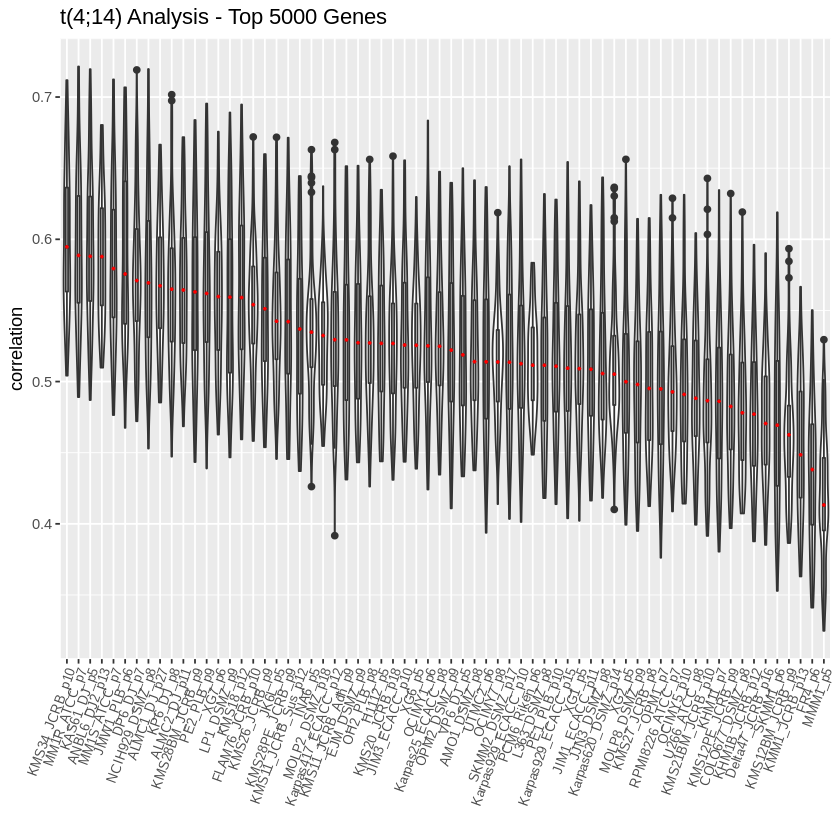

In [13]:
# extracting patients with 4;14 translocation who are also newly diagnosed

keep414 = as.logical(MM_patients_trans[,'t.4.14.'])
MM_patients_trans_414 = MM_patient_trans_ids[keep414]
MM_patients_trans_414 = unique(MM_patients_trans_414)
MM_patients_new_trans_414 = filter(as.data.frame(MM_patients_trans_414),
                                   str_extract(as.data.frame(MM_patients_trans_414)[,1], "_[0-9]_") == "_1_")
keepc414 = colnames(MM_patients) %in% MM_patients_new_trans_414[,1]

# subsetting norm_pat to those patients with translocation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_414 = norm_pat[,keepc414]
norm_combined_414 = cbind(norm_cell, norm_pat_414)
norm_combined_414_5000 = norm_combined_414[keepi5000, ]
# norm_combined_414_10000 = norm_combined_414[keepi10000, ]

# plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_414, colnames(norm_pat_414), 't(4;14) Analysis - All Genes')
makeplots(norm_combined_414_5000, colnames(norm_pat_414), colnames(MM_cell_line), 't(4;14) Analysis - Top 5000 Genes')
# makeplots(norm_combined_414_10000, colnames(norm_pat_414), 't(4;14) Analysis - Top 10000 Genes')

# determining top 5000 / 10000 genes from only patients that have 4;14 transloation

# keepi_t414 = apply(norm_pat_414, 1, IQR)
# keepis_t414 = sort(keepi_t414, decreasing = TRUE)
# keepi_t414_5000 = keepi_t414 %in% keepis_t414[1:5000]
# # keepi_t414_10000 = keepi_t414 %in% keepis_t414[1:10000]

# subsetting norm_pat to keep newly filtered genes

# norm_combined_414_u_5000 = norm_combined_414[keepi_t414_5000, ]
# norm_combined_414_u_10000 = norm_combined_414[keepi_t414_10000, ]

# plots using newly filtered genes

# makeplots(norm_combined_414_u_5000, colnames(norm_pat_414), 't(4;14) Analysis - Top 5000 Genes Subsetted from patients harboring translocation')
# makeplots(norm_combined_414_u_10000, colnames(norm_pat_414), 't(4;14) Analysis - Top 10000 Genes Subsetted from patients harboring translocation')


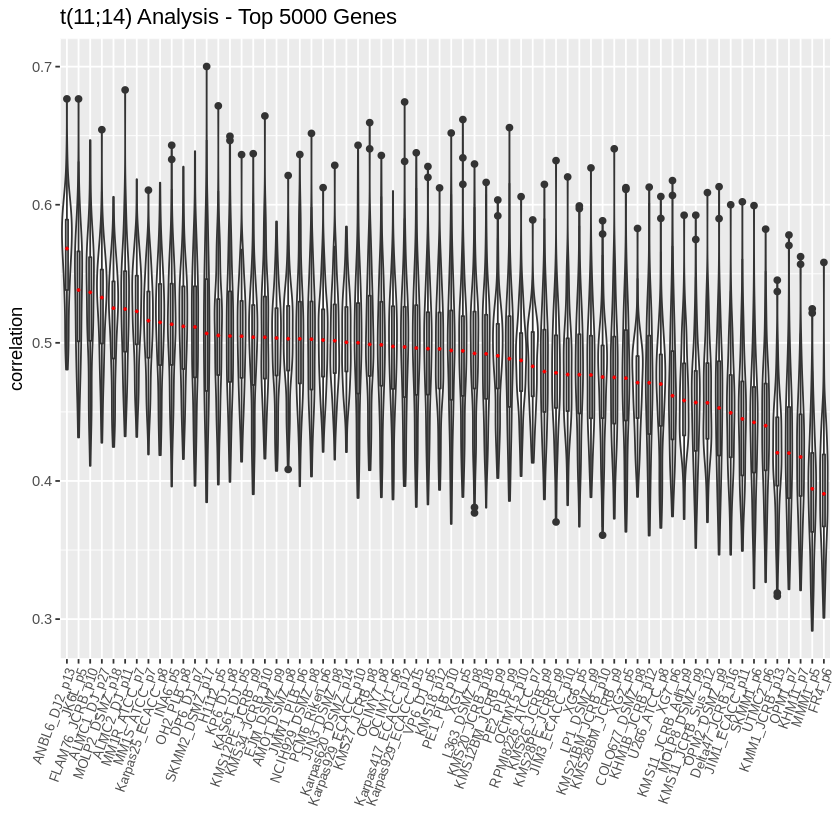

In [14]:
# extracting patients with 11;14 translocation who are also newly diagnosed

keep1114 = as.logical(MM_patients_trans[,'t.11.14.'])
MM_patients_trans_1114 = MM_patient_trans_ids[keep1114]
MM_patients_trans_1114 = unique(MM_patients_trans_1114)
MM_patients_new_trans_1114 = filter(as.data.frame(MM_patients_trans_1114),
                                   str_extract(as.data.frame(MM_patients_trans_1114)[,1], "_[0-9]_") == "_1_")
keepc1114 = colnames(MM_patients) %in% MM_patients_new_trans_1114[,1]

# subsetting norm_pat to those patients with translocation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_1114 = norm_pat[,keepc1114]
norm_combined_1114 = cbind(norm_cell, norm_pat_1114)
norm_combined_1114_5000 = norm_combined_1114[keepi5000, ]
# norm_combined_1114_10000 = norm_combined_1114[keepi10000, ]

# plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_1114, colnames(norm_pat_1114), 't(11;14) Analysis - All Genes')
makeplots(norm_combined_1114_5000, colnames(norm_pat_1114), colnames(MM_cell_line), 't(11;14) Analysis - Top 5000 Genes')
# makeplots(norm_combined_1114_10000, colnames(norm_pat_1114), 't(11;14) Analysis - Top 10000 Genes')

# # determining top 5000 / 10000 genes from only patients that have 11;14 transloation

# keepi_t1114 = apply(norm_pat_1114, 1, IQR)
# keepis_t1114 = sort(keepi_t1114, decreasing = TRUE)
# keepi_t1114_5000 = keepi_t1114 %in% keepis_t1114[1:5000]
# keepi_t1114_10000 = keepi_t1114 %in% keepis_t1114[1:10000]

# # subsetting norm_pat to keep newly filtered genes

# norm_combined_1114_u_5000 = norm_combined_1114[keepi_t1114_5000, ]
# norm_combined_1114_u_10000 = norm_combined_1114[keepi_t1114_10000, ]

# # plots using newly filtered genes

# makeplots(norm_combined_1114_u_5000, colnames(norm_pat_1114), 't(11;14) Analysis - Top 5000 Genes Subsetted from patients harboring translocation')
# makeplots(norm_combined_1114_u_10000, colnames(norm_pat_1114), 't(11;14) Analysis - Top 10000 Genes Subsetted from patients harboring translocation')

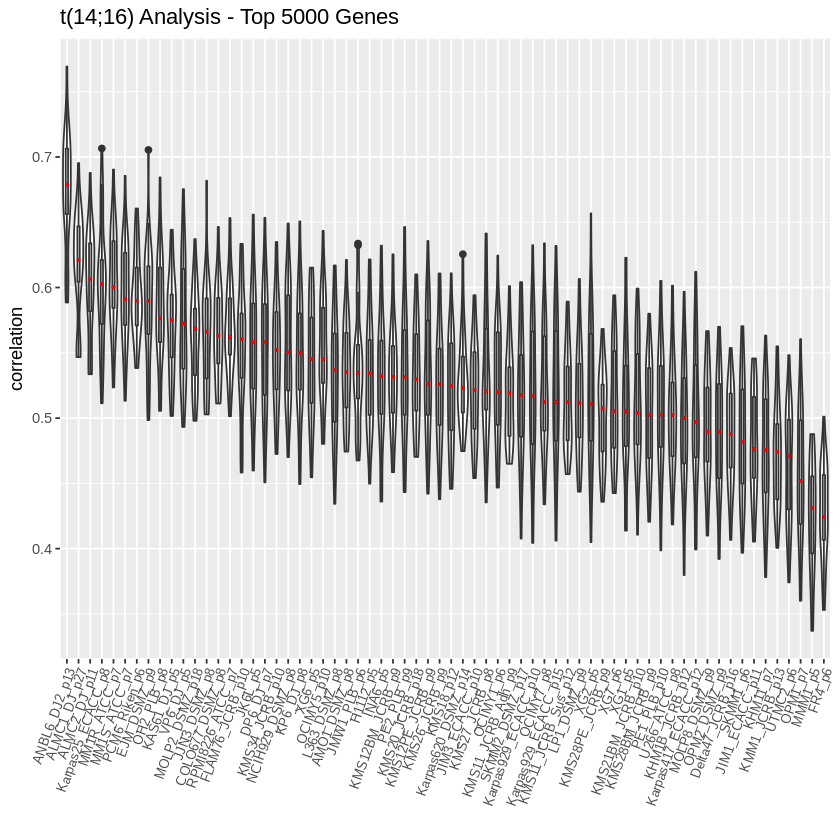

In [15]:
# extracting patients with 14;16 translocation who are also newly diagnosed

keep1416 = as.logical(MM_patients_trans[,'t.14.16.'])
MM_patients_trans_1416 = MM_patient_trans_ids[keep1416]
MM_patients_trans_1416 = unique(MM_patients_trans_1416)
MM_patients_new_trans_1416 = filter(as.data.frame(MM_patients_trans_1416),
                                   str_extract(as.data.frame(MM_patients_trans_1416)[,1], "_[0-9]_") == "_1_")
keepc1416 = colnames(MM_patients) %in% MM_patients_new_trans_1416[,1]

# subsetting norm_pat to those patients with translocation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_1416 = norm_pat[,keepc1416]
norm_combined_1416 = cbind(norm_cell, norm_pat_1416)
norm_combined_1416_5000 = norm_combined_1416[keepi5000, ]
# norm_combined_1416_10000 = norm_combined_1416[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_1416, colnames(norm_pat_1416), 't(14;16) Analysis - All Genes')
makeplots(norm_combined_1416_5000, colnames(norm_pat_1416), colnames(MM_cell_line), 't(14;16) Analysis - Top 5000 Genes')
# makeplots(norm_combined_1416_10000, colnames(norm_pat_1416), 't(14;16) Analysis - Top 10000 Genes')

# # determining top 5000 / 10000 genes from only patients that have 14;16 transloation

# keepi_t1416 = apply(norm_pat_1416, 1, IQR)
# keepis_t1416 = sort(keepi_t1416, decreasing = TRUE)
# keepi_t1416_5000 = keepi_t1416 %in% keepis_t1416[1:5000]
# keepi_t1416_10000 = keepi_t1416 %in% keepis_t1416[1:10000]

# # subsetting norm_pat to keep newly filtered genes

# norm_combined_1416_u_5000 = norm_combined_1416[keepi_t1416_5000, ]
# norm_combined_1416_u_10000 = norm_combined_1416[keepi_t1416_10000, ]

# # plots using newly filtered genes

# makeplots(norm_combined_1416_u_5000, colnames(norm_pat_1416), 't(14;16) Analysis - Top 5000 Genes Subsetted from patients harboring translocation')
# makeplots(norm_combined_1416_u_10000, colnames(norm_pat_1416), 't(14;16) Analysis - Top 10000 Genes Subsetted from patients harboring translocation')

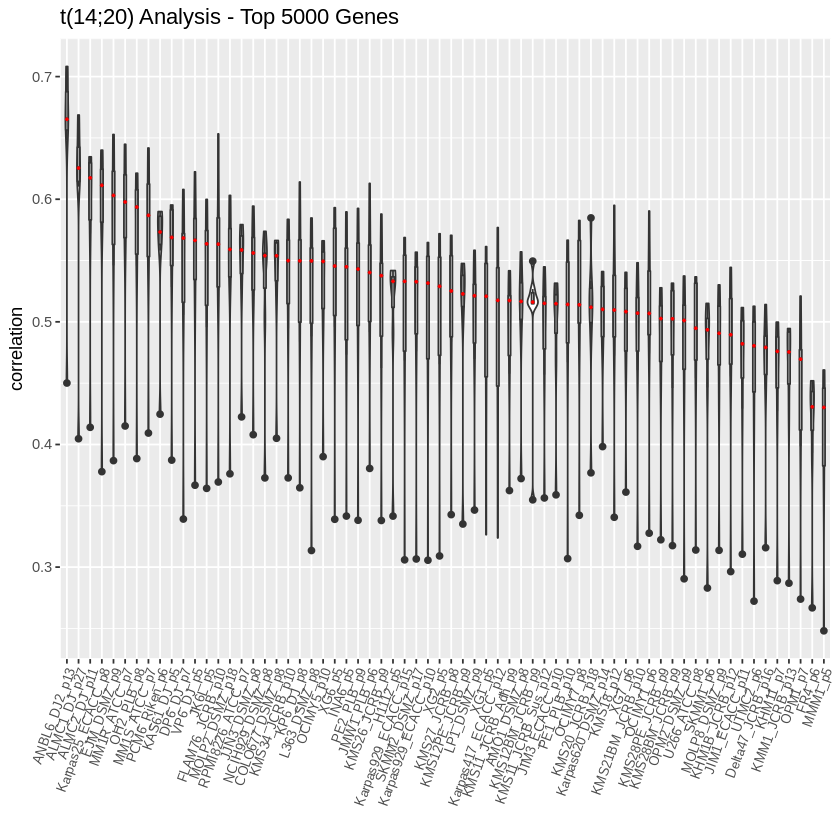

In [16]:
# extracting patients with 14;16 translocation who are also newly diagnosed

keep1420 = as.logical(MM_patients_trans[,'t.14.20.'])
MM_patients_trans_1420 = MM_patient_trans_ids[keep1420]
MM_patients_trans_1420 = unique(MM_patients_trans_1420)
MM_patients_new_trans_1420 = filter(as.data.frame(MM_patients_trans_1420),
                                   str_extract(as.data.frame(MM_patients_trans_1420)[,1], "_[0-9]_") == "_1_")
keepc1420 = colnames(MM_patients) %in% MM_patients_new_trans_1420[,1]

# subsetting norm_pat to those patients with translocation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_1420 = norm_pat[,keepc1420]
norm_combined_1420 = cbind(norm_cell, norm_pat_1420)
norm_combined_1420_5000 = norm_combined_1420[keepi5000, ]
# norm_combined_1416_10000 = norm_combined_1416[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_1416, colnames(norm_pat_1416), 't(14;16) Analysis - All Genes')
makeplots(norm_combined_1420_5000, colnames(norm_pat_1420), colnames(MM_cell_line), 't(14;20) Analysis - Top 5000 Genes')
# makeplots(norm_combined_1416_10000, colnames(norm_pat_1416), 't(14;16) Analysis - Top 10000 Genes')

# # determining top 5000 / 10000 genes from only patients that have 14;16 transloation

# keepi_t1416 = apply(norm_pat_1416, 1, IQR)
# keepis_t1416 = sort(keepi_t1416, decreasing = TRUE)
# keepi_t1416_5000 = keepi_t1416 %in% keepis_t1416[1:5000]
# keepi_t1416_10000 = keepi_t1416 %in% keepis_t1416[1:10000]

# # subsetting norm_pat to keep newly filtered genes

# norm_combined_1416_u_5000 = norm_combined_1416[keepi_t1416_5000, ]
# norm_combined_1416_u_10000 = norm_combined_1416[keepi_t1416_10000, ]

# # plots using newly filtered genes

# makeplots(norm_combined_1416_u_5000, colnames(norm_pat_1416), 't(14;16) Analysis - Top 5000 Genes Subsetted from patients harboring translocation')
# makeplots(norm_combined_1416_u_10000, colnames(norm_pat_1416), 't(14;16) Analysis - Top 10000 Genes Subsetted from patients harboring translocation')

In [17]:
#### Cell line info ####

MM_pat_mut = read.delim("MMRF_CoMMpass_IA13a_IGV_All_Canonical_Variants.mut", stringsAsFactors = F)

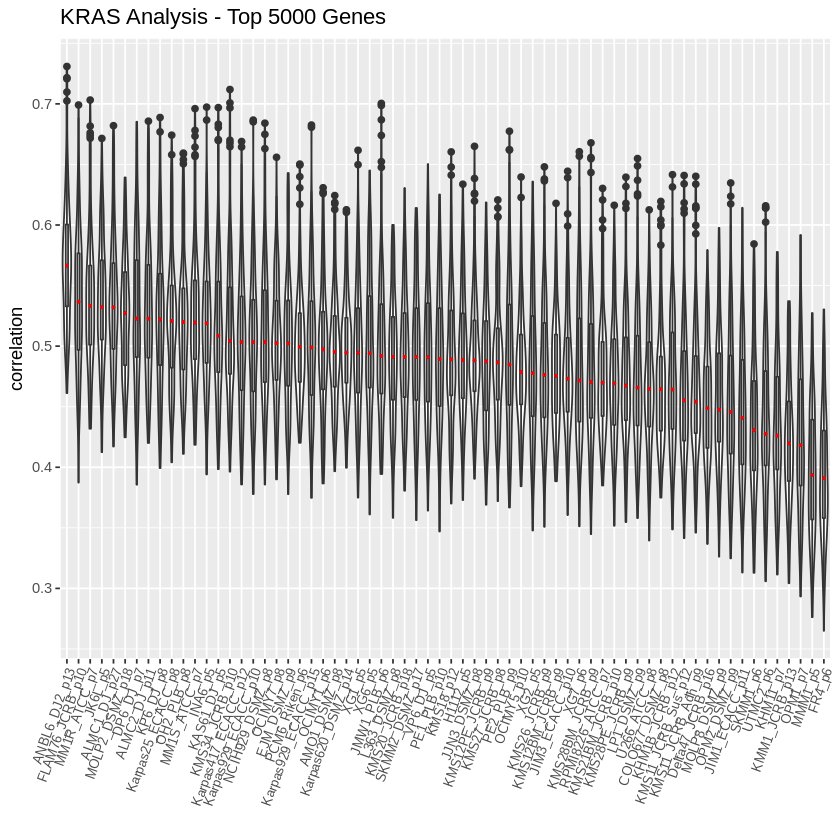

In [18]:
# extracting patients with KRAS mutation who are also newly diagnosed

KRAS_mut = filter(MM_pat_mut, GENE == "KRAS") %>%
  select(sample, EFFECT, HGVS_P, FEATURE) %>%
  filter(EFFECT == "missense_variant") %>%
  mutate(position = str_extract(HGVS_P, "[0-9]+")) %>%
  filter(position %in% c(12, 13, 61))

MM_pat_mut_KRAS = unique(KRAS_mut$sample)
keepcKRAS = colnames(MM_patients) %in% MM_pat_mut_KRAS

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_KRAS = norm_pat[,keepcKRAS]
norm_combined_KRAS = cbind(norm_cell, norm_pat_KRAS)
norm_combined_KRAS_5000 = norm_combined_KRAS[keepi5000, ]
# norm_combined_KRAS_10000 = norm_combined_KRAS[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_KRAS, colnames(norm_pat_KRAS), 'KRAS Analysis - All Genes')
makeplots(norm_combined_KRAS_5000, colnames(norm_pat_KRAS), colnames(MM_cell_line), 'KRAS Analysis - Top 5000 Genes')
# makeplots(norm_combined_KRAS_10000, colnames(norm_pat_KRAS), 'KRAS Analysis - Top 10000 Genes')

# # determining top 5000 / 10000 genes from only patients that have 14;16 transloation

# keepi_KRAS = apply(norm_pat_KRAS, 1, IQR)
# keepis_KRAS = sort(keepi_KRAS, decreasing = TRUE)
# keepi_KRAS_5000 = keepi_KRAS %in% keepis_KRAS[1:5000]
# keepi_KRAS_10000 = keepi_KRAS %in% keepis_KRAS[1:10000]

# # subsetting norm_pat to keep newly filtered genes

# norm_combined_KRAS_u_5000 = norm_combined_KRAS[keepi_KRAS_5000, ]
# norm_combined_KRAS_u_10000 = norm_combined_KRAS[keepi_KRAS_10000, ]

# # plots using newly filtered genes

# makeplots(norm_combined_KRAS_u_5000, colnames(norm_pat_KRAS), 'KRAS Analysis - Top 5000 Genes Subsetted from patients harboring mutation')
# makeplots(norm_combined_KRAS_u_10000, colnames(norm_pat_KRAS), 'KRAS Analysis - Top 10000 Genes Subsetted from patients harboring mutation')

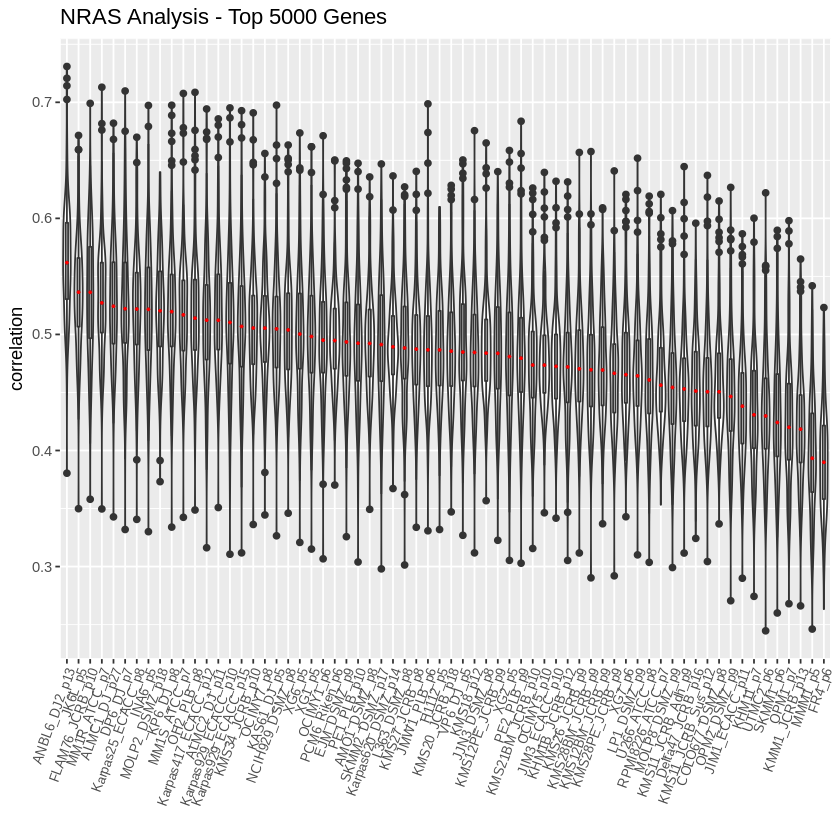

In [19]:
# extracting patients with NRAS mutation who are also newly diagnosed

NRAS_mut = filter(MM_pat_mut, GENE == "NRAS") %>%
  select(sample, EFFECT, HGVS_P, FEATURE) %>%
  filter(EFFECT == "missense_variant") %>%
  mutate(position = str_extract(HGVS_P, "[0-9]+")) %>%
  filter(position %in% c(12, 13, 61))

MM_pat_mut_NRAS = unique(NRAS_mut$sample)
keepcNRAS = colnames(MM_patients) %in% MM_pat_mut_NRAS

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_NRAS = norm_pat[,keepcNRAS]
norm_combined_NRAS = cbind(norm_cell, norm_pat_NRAS)
norm_combined_NRAS_5000 = norm_combined_NRAS[keepi5000, ]
# norm_combined_NRAS_10000 = norm_combined_NRAS[keepi10000, ]

# plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_NRAS, colnames(norm_pat_NRAS), 'NRAS Analysis - All Genes')
makeplots(norm_combined_NRAS_5000, colnames(norm_pat_NRAS), colnames(MM_cell_line), 'NRAS Analysis - Top 5000 Genes')
# makeplots(norm_combined_NRAS_10000, colnames(norm_pat_NRAS), 'NRAS Analysis - Top 10000 Genes')

# # determining top 5000 / 10000 genes from only patients that have 14;16 transloation

# keepi_NRAS = apply(norm_pat_NRAS, 1, IQR)
# keepis_NRAS = sort(keepi_NRAS, decreasing = TRUE)
# keepi_NRAS_5000 = keepi_NRAS %in% keepis_NRAS[1:5000]
# # keepi_NRAS_10000 = keepi_NRAS %in% keepis_NRAS[1:10000]

# # subsetting norm_pat to keep newly filtered genes

# norm_combined_NRAS_u_5000 = norm_combined_NRAS[keepi_NRAS_5000, ]
# norm_combined_NRAS_u_10000 = norm_combined_NRAS[keepi_NRAS_10000, ]

# # plots using newly filtered genes

# makeplots(norm_combined_NRAS_u_5000, colnames(norm_pat_NRAS), 'NRAS Analysis - Top 5000 Genes Subsetted from patients harboring mutation')
# makeplots(norm_combined_NRAS_u_10000, colnames(norm_pat_NRAS), 'NRAS Analysis - Top 10000 Genes Subsetted from patients harboring mutation')

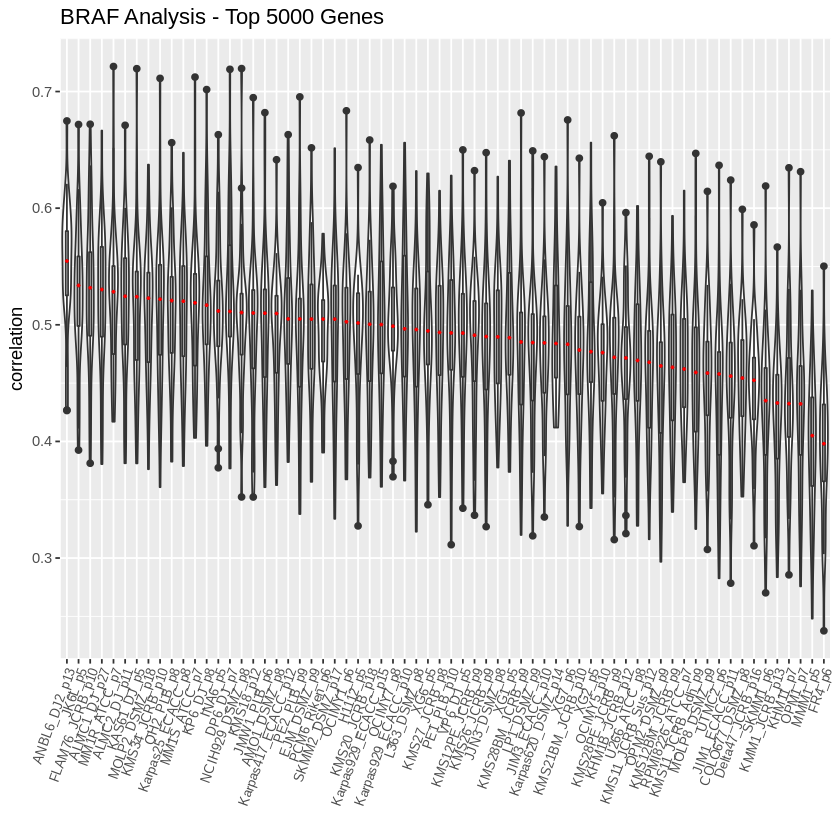

In [20]:
# extracting patients with BRAF mutation who are also newly diagnosed

BRAF_mut = filter(MM_pat_mut, GENE == "BRAF") %>%
  select(sample, EFFECT, HGVS_P, FEATURE) %>%
  filter(EFFECT == "missense_variant") %>%
  mutate(position = str_extract(HGVS_P, "[0-9]+")) %>%
  filter(position %in% c(600))

MM_pat_mut_BRAF = unique(BRAF_mut$sample)
keepcBRAF = colnames(MM_patients) %in% MM_pat_mut_BRAF

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_BRAF = norm_pat[,keepcBRAF]
norm_combined_BRAF = cbind(norm_cell, norm_pat_BRAF)
norm_combined_BRAF_5000 = norm_combined_BRAF[keepi5000, ]
# norm_combined_BRAF_10000 = norm_combined_BRAF[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_BRAF, colnames(norm_pat_BRAF), 'BRAF Analysis - All Genes')
makeplots(norm_combined_BRAF_5000, colnames(norm_pat_BRAF), colnames(MM_cell_line), 'BRAF Analysis - Top 5000 Genes')
# makeplots(norm_combined_BRAF_10000, colnames(norm_pat_BRAF), 'BRAF Analysis - Top 10000 Genes')

# # determining top 5000 / 10000 genes from only patients that have 14;16 transloation

# keepi_BRAF = apply(norm_pat_BRAF, 1, IQR)
# keepis_BRAF = sort(keepi_BRAF, decreasing = TRUE)
# keepi_BRAF_5000 = keepi_BRAF %in% keepis_BRAF[1:5000]
# keepi_BRAF_10000 = keepi_BRAF %in% keepis_BRAF[1:10000]

# subsetting norm_pat to keep newly filtered genes

# norm_combined_BRAF_u_5000 = norm_combined_BRAF[keepi_BRAF_5000, ]
# norm_combined_BRAF_u_10000 = norm_combined_BRAF[keepi_BRAF_10000, ]

# # plots using newly filtered genes

# makeplots(norm_combined_BRAF_u_5000, colnames(norm_pat_BRAF), 'BRAF Analysis - Top 5000 Genes Subsetted from patients harboring mutation')
# makeplots(norm_combined_BRAF_u_10000, colnames(norm_pat_BRAF), 'BRAF Analysis - Top 10000 Genes Subsetted from patients harboring mutation')

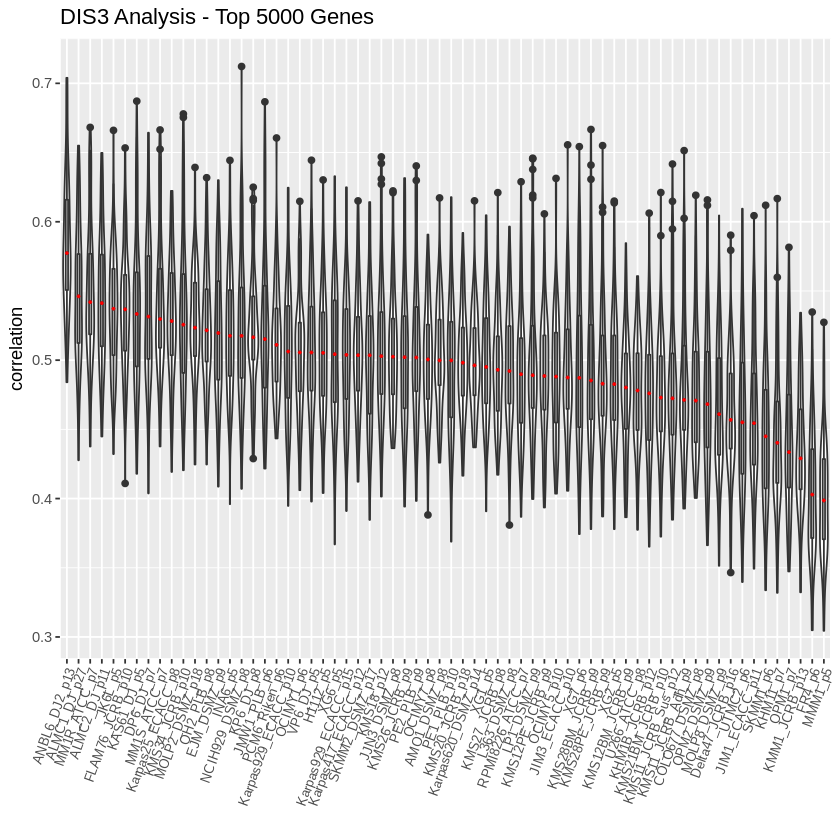

In [21]:
# extracting patients with DIS3 mutation who are also newly diagnosed

DIS3_mut = filter(MM_pat_mut, EFFECT %in% c("missense_variant",
                                         "frameshift_variant",
                                         "stop_gained",
                                         "start_lost",
                                         "stop_lost",
                                         "missense_variant&splice_region_variant",
                                         "frameshift_variant&splice_region_variant",
                                         "disruptive_inframe_deletion",
                                         "stop_gained&splice_region_variant",
                                         "frameshift_variant&stop_gained",
                                         "frameshift_variant&splice_acceptor_variant&splice_region_variant&intron_variant",
                                         "frameshift_variant&splice_donor_variant&splice_region_variant&intron_variant",
                                         "splice_donor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&splice_region_variant",
                                         "disruptive_inframe_insertion",
                                         "stop_gained&disruptive_inframe_deletion",
                                         "frameshift_variant&start_lost",
                                         "stop_gained&disruptive_inframe_insertion",
                                         "disruptive_inframe_deletion&splice_region_variant",
                                         "disruptive_inframe_insertion&splice_region_variant",
                                         "start_lost&splice_region_variant",
                                         "start_lost&inframe_deletion",
                                         "frameshift_variant&stop_lost",
                                         "splice_acceptor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&inframe_deletion")) %>%
  filter(str_extract(sample, "_[0-9]_") == "_1_")  %>%
  filter(GENE == 'DIS3')

MM_pat_mut_DIS3 = unique(DIS3_mut$sample)
keepcDIS3 = colnames(MM_patients) %in% MM_pat_mut_DIS3

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_DIS3 = norm_pat[,keepcDIS3]
norm_combined_DIS3 = cbind(norm_cell, norm_pat_DIS3)
norm_combined_DIS3_5000 = norm_combined_DIS3[keepi5000, ]
# norm_combined_DIS3_10000 = norm_combined_DIS3[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_DIS3, colnames(norm_pat_DIS3), 'DIS3 Analysis - All Genes')
makeplots(norm_combined_DIS3_5000, colnames(norm_pat_DIS3), colnames(MM_cell_line), 'DIS3 Analysis - Top 5000 Genes')
# makeplots(norm_combined_DIS3_10000, colnames(norm_pat_DIS3), 'DIS3 Analysis - Top 10000 Genes')

# # determining top 5000 / 10000 genes from only patients that have 14;16 transloation

# keepi_DIS3 = apply(norm_pat_DIS3, 1, IQR)
# keepis_DIS3 = sort(keepi_DIS3, decreasing = TRUE)
# keepi_DIS3_5000 = keepi_DIS3 %in% keepis_DIS3[1:5000]
# keepi_DIS3_10000 = keepi_DIS3 %in% keepis_DIS3[1:10000]

# # subsetting norm_pat to keep newly filtered genes

# norm_combined_DIS3_u_5000 = norm_combined_DIS3[keepi_DIS3_5000, ]
# norm_combined_DIS3_u_10000 = norm_combined_DIS3[keepi_DIS3_10000, ]

# # plots using newly filtered genes

# makeplots(norm_combined_DIS3_u_5000, colnames(norm_pat_DIS3), 'DIS3 Analysis - Top 5000 Genes Subsetted from patients harboring mutation')
# makeplots(norm_combined_DIS3_u_10000, colnames(norm_pat_DIS3), 'DIS3 Analysis - Top 10000 Genes Subsetted from patients harboring mutation')

[1] 88

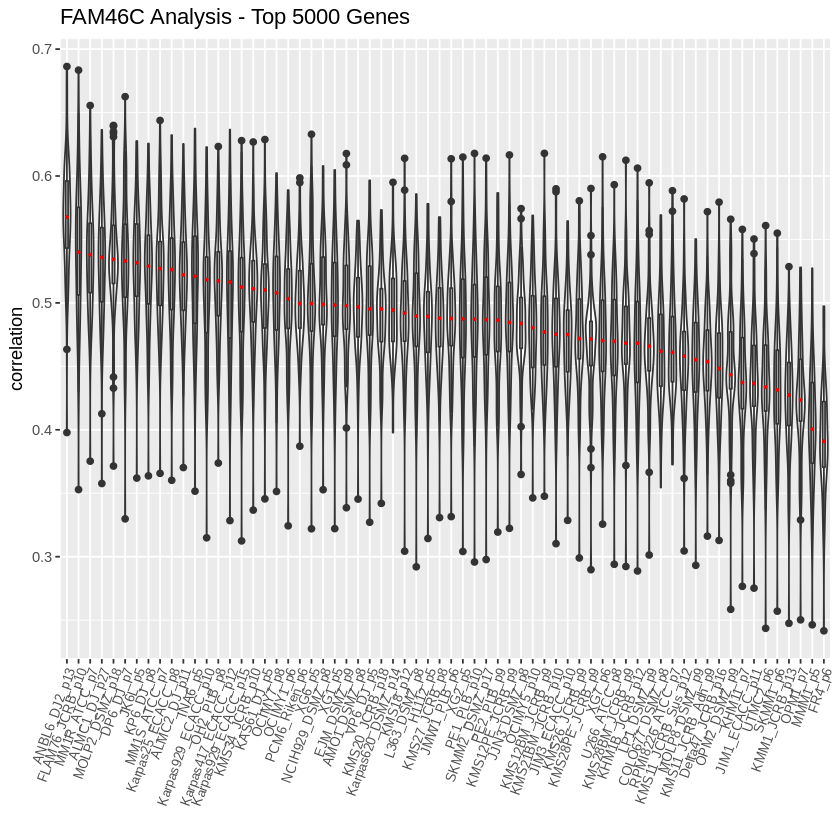

In [22]:
# extracting patients with FAM46C mutation who are also newly diagnosed

FAM46C_mut = filter(MM_pat_mut, EFFECT %in% c("missense_variant",
                                         "frameshift_variant",
                                         "stop_gained",
                                         "start_lost",
                                         "stop_lost",
                                         "missense_variant&splice_region_variant",
                                         "frameshift_variant&splice_region_variant",
                                         "disruptive_inframe_deletion",
                                         "stop_gained&splice_region_variant",
                                         "frameshift_variant&stop_gained",
                                         "frameshift_variant&splice_acceptor_variant&splice_region_variant&intron_variant",
                                         "frameshift_variant&splice_donor_variant&splice_region_variant&intron_variant",
                                         "splice_donor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&splice_region_variant",
                                         "disruptive_inframe_insertion",
                                         "stop_gained&disruptive_inframe_deletion",
                                         "frameshift_variant&start_lost",
                                         "stop_gained&disruptive_inframe_insertion",
                                         "disruptive_inframe_deletion&splice_region_variant",
                                         "disruptive_inframe_insertion&splice_region_variant",
                                         "start_lost&splice_region_variant",
                                         "start_lost&inframe_deletion",
                                         "frameshift_variant&stop_lost",
                                         "splice_acceptor_variant&disruptive_inframe_deletion&splice_region_variant&intron_variant",
                                         "stop_lost&inframe_deletion")) %>%
  filter(str_extract(sample, "_[0-9]_") == "_1_")  %>%
  filter(GENE == 'FAM46C')

MM_pat_mut_FAM46C = unique(FAM46C_mut$sample)
length(MM_pat_mut_FAM46C)
keepcFAM46C = colnames(MM_patients) %in% MM_pat_mut_FAM46C

# subsetting norm_pat to those patients with mutation, 
# then keeping genes prior analysed as top 5000, and 10000

norm_pat_FAM46C = norm_pat[,keepcFAM46C]
norm_combined_FAM46C = cbind(norm_cell, norm_pat_FAM46C)
norm_combined_FAM46C_5000 = norm_combined_FAM46C[keepi5000, ]
# norm_combined_FAM46C_10000 = norm_combined_FAM46C[keepi10000, ]

# # plots using all genes, and original 5000 / 10000 genes

# makeplots(norm_combined_FAM46C, colnames(norm_pat_FAM46C), 'FAM46C Analysis - All Genes')
makeplots(norm_combined_FAM46C_5000, colnames(norm_pat_FAM46C), colnames(MM_cell_line), 'FAM46C Analysis - Top 5000 Genes')
# makeplots(norm_combined_FAM46C_10000, colnames(norm_pat_FAM46C), 'FAM46C Analysis - Top 10000 Genes')

# # determining top 5000 / 10000 genes from only patients that have fam46C MUTATION

# keepi_FAM46C = apply(norm_pat_FAM46C, 1, IQR)
# keepis_FAM46C = sort(keepi_FAM46C, decreasing = TRUE)
# keepi_FAM46C_5000 = keepi_FAM46C %in% keepis_FAM46C[1:5000]
# keepi_FAM46C_10000 = keepi_FAM46C %in% keepis_FAM46C[1:10000]

# # subsetting norm_pat to keep newly filtered genes

# norm_combined_FAM46C_u_5000 = norm_combined_FAM46C[keepi_FAM46C_5000, ]
# norm_combined_FAM46C_u_10000 = norm_combined_FAM46C[keepi_FAM46C_10000, ]

# # plots using newly filtered genes

# makeplots(norm_combined_FAM46C_u_5000, colnames(norm_pat_FAM46C), 'FAM46C Analysis - Top 5000 Genes Subsetted from patients harboring mutation')
# makeplots(norm_combined_FAM46C_u_10000, colnames(norm_pat_FAM46C), 'FAM46C Analysis - Top 10000 Genes Subsetted from patients harboring mutation')

In [23]:
g2k = rownames(norm_combined)
CCLE_cell_line = data.frame(fread("CCLE_RNAseq_genes_counts_20180929.gct"))
gid = CCLE_cell_line$Name
gid2 = substr(gid, 1, 15)
rownames(CCLE_cell_line) = gid2

CCLE_cell_line = CCLE_cell_line[-1]
CCLE_cell_line = CCLE_cell_line[-1]

CCLE_cell_line_meta = data.frame(fread("Cell_lines_annotations_20181226.txt"))
CCLE_cell_line_meta_2 = CCLE_cell_line_meta[(CCLE_cell_line_meta$type == 'multiple_myeloma'),]

CCLE_bool2 = colnames(CCLE_cell_line) %in% CCLE_cell_line_meta_2$CCLE_ID
CCLE_cell_line = CCLE_cell_line[,CCLE_bool2]
CCLE_cell_line = CCLE_cell_line[g2k,]
length(CCLE_cell_line[,1])
head(CCLE_cell_line)

[1] 22459

AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003    56                                  
ENSG00000000419 10884                                  
ENSG00000000457  2572                                  
ENSG00000000460  3844                                  
ENSG00000000938  3761                                  
ENSG00000000971    51                                  
                EJM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003  642                                  
ENSG00000000419 7383                                  
ENSG00000000457 1482                                  
ENSG00000000460 2741                                  
ENSG00000000938    4                                  
ENSG00000000971   54                                  
                HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003   15                                    
ENSG00000000419 7458                                    
ENSG00000000457 2286                                    
ENSG00000000460 5379                                    
ENSG00000000938   17                                    
ENSG00000000971   18                                    
                JJN3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003   17                                   
ENSG00000000419 5989                                   
ENSG00000000457 2691                                   
ENSG00000000460 3464                                   
ENSG00000000938   18                                   
ENSG00000000971 1617                                   
                KARPAS620_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003  204                                        
ENSG00000000419 5646                                        
ENSG00000000457 1948                                        
ENSG00000000460 2487                                        
ENSG00000000938 4547                                        
ENSG00000000971   36                                        
                KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003    13                                  
ENSG00000000419  9925                                  
ENSG00000000457  1876                                  
ENSG00000000460  2782                                  
ENSG00000000938 13572                                  
ENSG00000000971    62                                  
                KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003     4                                   
ENSG00000000419  4271                                   
ENSG00000000457  2182                                   
ENSG00000000460  2757                                   
ENSG00000000938 11348                                   
ENSG00000000971    11                                   
                KMM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003    7                                   
ENSG00000000419 5864                                   
ENSG00000000457 2068                                   
ENSG00000000460 2402                                   
ENSG00000000938   42                                   
ENSG00000000971  155                                   
                KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003   14                                    
ENSG00000000419 5662                                    
ENSG00000000457 2849                                    
ENSG00000000460 5753                                    
ENSG00000000938    2                                    
ENSG00000000971   27                                    
                KMS12BM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE ⋯
ENSG00000000003   24                                       ⋯
ENSG00000000419 7070                                       ⋯
ENSG00000000457 2044                                       ⋯
ENSG00000000460 4794                                       ⋯
ENSG00000000938    9                                       ⋯
ENSG00000000971   12                                       ⋯
            

In [24]:
# colnames(CCLE_cell_line)
# colnames(MM_cell_line)
CCLE_cell_names = c('AMO1_DSMZ_p8', 'EJM_DSMZ_p9', 'HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
                   'JJN3_DSMZ_p8', 'Karpas620_DSMZ_p14', 'KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
                   'KHM1B_JCRB_p12', 'KMM1_JCRB_p13', 'KMS11_JCRB_Sus_p12', 'KMS12BM_JCRB_p9',
                   'KMS18_p12', 'KMS20_JCRB_p18', 'KMS21BM_JCRB_p10', 'KMS26_JCRB_p9', 'KMS27_JCRB_p8',
                   'KMS28BM_JCRB_p9', 'KMS34_JCRB_p10', 'L363_DSMZ_p8', 'LP1_DSMZ_p9', 'MM1S_ATCC_p7',
                   'MOLP2_DSMZ_p18', 'MOLP8_DSMZ_p9', 'NCIH929_DSMZ_p8', 'OPM2_DSMZ_p9',
                   'RPMI8226_ATCC_p7', 'SKMM2_DSMZ_p17', 'U266_ATCC_p8')
colnames(CCLE_cell_line) = CCLE_cell_names
head(CCLE_cell_line)

AMO1_DSMZ_p8 EJM_DSMZ_p9
ENSG00000000003    56         642       
ENSG00000000419 10884        7383       
ENSG00000000457  2572        1482       
ENSG00000000460  3844        2741       
ENSG00000000938  3761           4       
ENSG00000000971    51          54       
                HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE JJN3_DSMZ_p8
ENSG00000000003   15                                       17        
ENSG00000000419 7458                                     5989        
ENSG00000000457 2286                                     2691        
ENSG00000000460 5379                                     3464        
ENSG00000000938   17                                       18        
ENSG00000000971   18                                     1617        
                Karpas620_DSMZ_p14 KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003  204                  13                                  
ENSG00000000419 5646                9925                                  
ENSG00000000457 1948                1876                                  
ENSG00000000460 2487                2782                                  
ENSG00000000938 4547               13572                                  
ENSG00000000971   36                  62                                  
                KHM1B_JCRB_p12 KMM1_JCRB_p13 KMS11_JCRB_Sus_p12 KMS12BM_JCRB_p9
ENSG00000000003     4             7            14                 24           
ENSG00000000419  4271          5864          5662               7070           
ENSG00000000457  2182          2068          2849               2044           
ENSG00000000460  2757          2402          5753               4794           
ENSG00000000938 11348            42             2                  9           
ENSG00000000971    11           155            27                 12           
                ⋯ L363_DSMZ_p8 LP1_DSMZ_p9 MM1S_ATCC_p7 MOLP2_DSMZ_p18
ENSG00000000003 ⋯    16          30           22          26          
ENSG00000000419 ⋯ 12073        9589        10297        7354          
ENSG00000000457 ⋯  4243        5365         3481        2653          
ENSG00000000460 ⋯  6044        1237         6129        1202          
ENSG00000000938 ⋯    62           5           20         397          
ENSG00000000971 ⋯    18          47           44          31          
                MOLP8_DSMZ_p9 NCIH929_DSMZ_p8 OPM2_DSMZ_p9 RPMI8226_ATCC_p7
ENSG00000000003    27            26              14          29            
ENSG00000000419  7369         42842           20907        5507            
ENSG00000000457  3947          5933            3214        1439            
ENSG00000000460  2375          4064            2694        2784            
ENSG00000000938 29998          5497            3775          10            
ENSG00000000971  1328            29             336         440            
                SKMM2_DSMZ_p17 U266_ATCC_p8
ENSG00000000003   16             31        
ENSG00000000419 7197           3544        
ENSG00000000457 1739           1797        
ENSG00000000460 2183           2438        
ENSG00000000938 1288            369        
ENSG00000000971 1044             41

In [25]:
MM_combined_CCLE.filtered = cbind(CCLE_cell_line, MM_patients)
head(MM_combined_CCLE.filtered)

AMO1_DSMZ_p8 EJM_DSMZ_p9
ENSG00000000003    56         642       
ENSG00000000419 10884        7383       
ENSG00000000457  2572        1482       
ENSG00000000460  3844        2741       
ENSG00000000938  3761           4       
ENSG00000000971    51          54       
                HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE JJN3_DSMZ_p8
ENSG00000000003   15                                       17        
ENSG00000000419 7458                                     5989        
ENSG00000000457 2286                                     2691        
ENSG00000000460 5379                                     3464        
ENSG00000000938   17                                       18        
ENSG00000000971   18                                     1617        
                Karpas620_DSMZ_p14 KE97_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
ENSG00000000003  204                  13                                  
ENSG00000000419 5646                9925                                  
ENSG00000000457 1948                1876                                  
ENSG00000000460 2487                2782                                  
ENSG00000000938 4547               13572                                  
ENSG00000000971   36                  62                                  
                KHM1B_JCRB_p12 KMM1_JCRB_p13 KMS11_JCRB_Sus_p12 KMS12BM_JCRB_p9
ENSG00000000003     4             7            14                 24           
ENSG00000000419  4271          5864          5662               7070           
ENSG00000000457  2182          2068          2849               2044           
ENSG00000000460  2757          2402          5753               4794           
ENSG00000000938 11348            42             2                  9           
ENSG00000000971    11           155            27                 12           
                ⋯ MMRF_1731_1_BM MMRF_2799_1_BM MMRF_2379_1_BM MMRF_1474_1_BM
ENSG00000000003 ⋯    1             49              2           186           
ENSG00000000419 ⋯  493            220            734           771           
ENSG00000000457 ⋯  104             50            267           104           
ENSG00000000460 ⋯ 3064             46             46            14           
ENSG00000000938 ⋯ 2566             27             13             5           
ENSG00000000971 ⋯ 2079           1843           5195           911           
                MMRF_1641_1_BM MMRF_2795_1_BM MMRF_2316_1_BM MMRF_2440_1_BM
ENSG00000000003 102             128             17              3          
ENSG00000000419 327              90            406            548          
ENSG00000000457 114              17             67            141          
ENSG00000000460 303              58             77             11          
ENSG00000000938  28              30             18           1680          
ENSG00000000971 548            1305           4679           1419          
                MMRF_2731_1_BM MMRF_1355_1_BM
ENSG00000000003  18              6           
ENSG00000000419 808            393           
ENSG00000000457 199             55           
ENSG00000000460 174             22           
ENSG00000000938  56             10           
ENSG00000000971 695            701

In [26]:

MM_combined_CCLE.filtered[is.na(MM_combined_CCLE.filtered)] <- 0

norm_CCLE_combined = vst(as.matrix(MM_combined_CCLE.filtered))
bool2 = rownames(norm_CCLE_combined) %in% names(keepis[1:5000])
norm_CCLE_combined_5000 = norm_CCLE_combined[bool2,]#keepi5000, ]

converting counts to integer mode


In [27]:
# head(rownames(norm_CCLE_combined) %in% names(keepis[1:5000])) 
# # head(names(keepis[1:5000]) %in% rownames(norm_CCLE_combined))
# head(norm_CCLE_combined[names(keepis[1:5000]),])

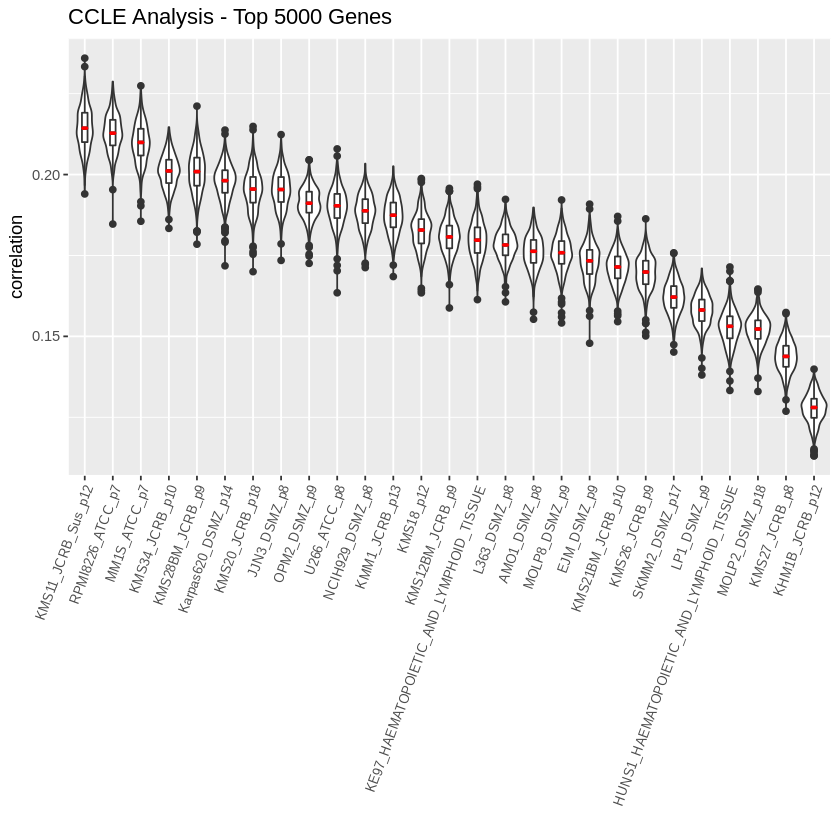

In [28]:
MM.cor.ccle = cor(norm_CCLE_combined_5000, method = "s")
makeplots(norm_CCLE_combined_5000, colnames(MM_patients), colnames(CCLE_cell_line), 'CCLE Analysis - Top 5000 Genes')


In [28]:
cell_names_414 = c('JIM1_ECACC_p11', 'JIM3_ECACC_p10', 'JMW1_PLB_p6', 'KAS61_DJ_p5', 'KHM11_p7', 
                  'KMS11_JCRB_Adh_p9', 'KMS11_JCRB_Sus_p12', 'KMS18_p12', 'KMS26_JCRB_p9',
                  'KMS28BM_JCRB_p9', 'KMS28PE_JCRB_p9', 'KMS34_JCRB_p10', 'LP1_DSMZ_p9',
                  'NCIH929_DSMZ_p8', 'OPM1_p7', 'OPM2_DSMZ_p9', 'PE2_PLB_p9', 'UTMC2_p6',
                  'XG7_p6')

cell_names_1114 = c('FLAM76_JCRB_p10', 'H1112_p5', 'INA6_p5', 'Karpas620_DSMZ_p14', 'KMS12BM_JCRB_p9',
                   'KMS12PE_JCRB_p9', 'KMS21BM_JCRB_p10', 'KMS27_JCRB_p8', 'MMM1_p5', 'MOLP8_DSMZ_p9',
                   'OCIMY7_p8', 'PE1_PLB_p10', 'SKMM2_DSMZ_p17', 'U266_ATCC_p8', 'XG1_p5')

cell_names_1416 = c('ANBL6_DJ2_p13', 'JJN3_DSMZ_p8', 'KMS11_JCRB_Adh_p9', 'KMS11_JCRB_Sus_p12',
                   'MM1R_ATCC_p7', 'MM1S_ATCC_p7', 'OCIMY5_p10', 'PCM6_Riken_p6', 'VP6_DJ_p5')

cell_names_1420 = c('ALMC1_DJ_p27', 'ALMC2_DJ_p11', 'EJM_DSMZ_p9', 'Karpas25_ECACC_p8', 'OH2_PLB_p8', 'SKMM1_p6')

ERROR: Error in parse(text = x, srcfile = src): <text>:1:35: unexpected ','
1: cell_names_414 = ('JIM1_ECACC_p11',
                                      ^


In [ ]:
############## TEST CODE FOLLOWS RUN ABOVE FROM HERE #####################

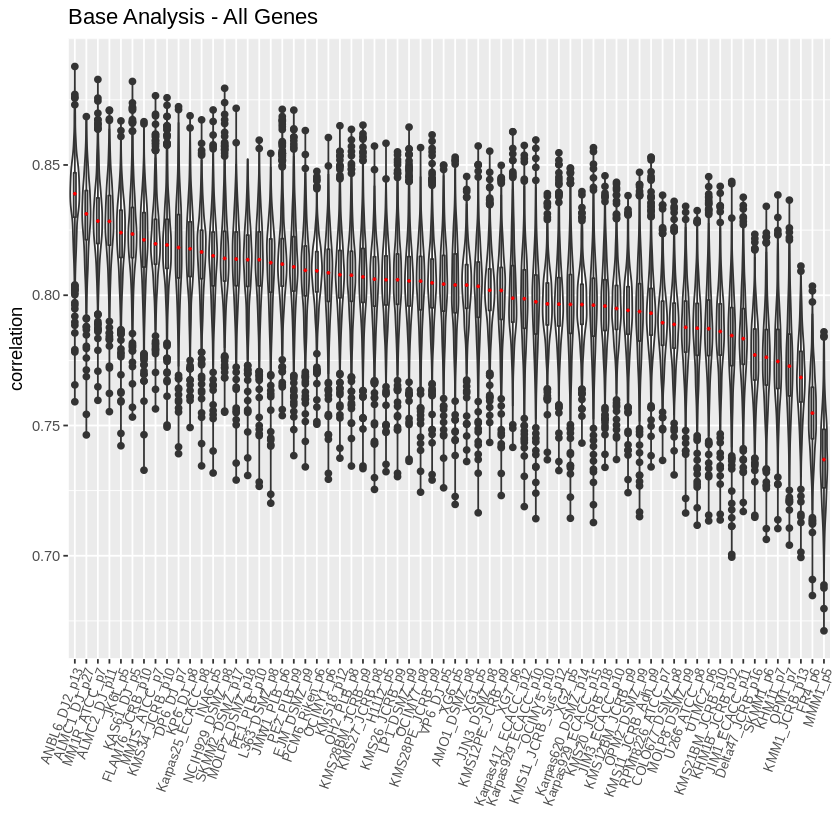

In [47]:
# # plots for main analysis using all genes

# ranks = makeplots(norm_combined, colnames(MM_patients), 'Base Analysis - All Genes')
# #ranks[order(ranks$cor, decreasing = TRUE),]#order(ranks$cor)]
# #ranks$rank = c(1:nrows(ranks))
# #head(ranks)
# # # subsetting top 5000 / 10000 genes

# # norm_combined_5000 = norm_combined[keepi5000, ]
# # norm_combined_10000 = norm_combined[keepi10000, ]

# # # plots for main analysis using top 5000 / 10000 genes

# # makeplots(norm_combined_5000, colnames(MM_patients), 'Base Analysis - Top 5000 Genes')
# # makeplots(norm_combined_10000, colnames(MM_patients), 'Base Analysis - Top 10000 Genes')

In [48]:
# ranks = ranks[order(ranks$cor, decreasing = TRUE),]#order(ranks$cor)]
# ranks = as.data.frame(ranks)
# ranks$rank = c(1:nrow(ranks))
# head(ranks)

sample        cor       rank
4  ANBL6_DJ2_p13 0.8389621 1   
1  ALMC1_DJ_p27  0.8312302 2   
42 MM1R_ATCC_p7  0.8284668 3   
2  ALMC2_DJ_p11  0.8283566 4   
16 JK6L_p5       0.8240218 5   
23 KAS61_DJ_p5   0.8234968 6

In [49]:
# rownames(ranks) = ranks$sample
# ranks = ranks[-1]
# head(ranks)

cor       rank
ANBL6_DJ2_p13 0.8389621 1   
ALMC1_DJ_p27  0.8312302 2   
MM1R_ATCC_p7  0.8284668 3   
ALMC2_DJ_p11  0.8283566 4   
JK6L_p5       0.8240218 5   
KAS61_DJ_p5   0.8234968 6

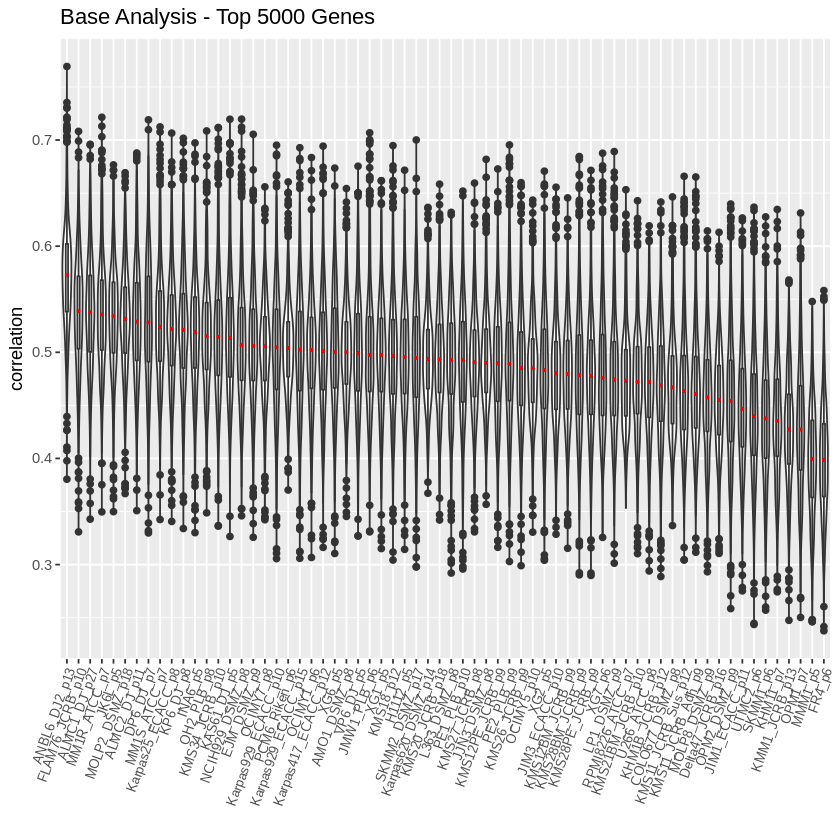

In [54]:
# norm_combined_5000 = norm_combined[names(keepi5000), ]
# ranks2 = makeplots(norm_combined_5000, colnames(MM_patients), 'Base Analysis - Top 5000 Genes')

In [55]:
# #ranks2
# ranks2 = ranks2[order(ranks2$cor, decreasing = TRUE),]#order(ranks$cor)]
# ranks2 = as.data.frame(ranks2)
# ranks2$rank = c(1:nrow(ranks2))
# head(ranks2)

sample              cor      
1  ALMC1_DJ_p27        0.5375806
2  ALMC2_DJ_p11        0.5288968
3  AMO1_DSMZ_p8        0.5002585
4  ANBL6_DJ2_p13       0.5731225
5  COLO677_DSMZ_p8     0.4669203
6  Delta47_JCRB_p16    0.4552341
7  DP6_DJ_p7           0.5281659
8  EJM_DSMZ_p9         0.5061825
9  FLAM76_JCRB_p10     0.5390818
10 FR4_p6              0.3984927
11 H1112_p5            0.4957503
12 INA6_p5             0.5189480
13 JIM1_ECACC_p11      0.4463833
14 JIM3_ECACC_p10      0.4801933
15 JJN3_DSMZ_p8        0.4899726
16 JK6L_p5             0.5339660
17 JMW1_PLB_p6         0.4975923
18 Karpas25_ECACC_p8   0.5222020
19 Karpas417_ECACC_p12 0.5011777
20 Karpas620_DSMZ_p14  0.4935681
21 Karpas929_ECACC_p10 0.5046141
22 Karpas929_ECACC_p15 0.5026727
23 KAS61_DJ_p5         0.5137384
24 KHM11_p7            0.4355331
25 KHM1B_JCRB_p12      0.4688181
26 KMM1_JCRB_p13       0.4272983
27 KMS11_JCRB_Adh_p9   0.4606476
28 KMS11_JCRB_Sus_p12  0.4637136
29 KMS12BM_JCRB_p9     0.4797671
30 KMS12PE_JCRB_p9     0.4895671
⋮  ⋮                   ⋮        
37 KMS28PE_JCRB_p9     0.4778074
38 KMS34_JCRB_p10      0.5145684
39 KP6_DJ_p8           0.5212936
40 L363_DSMZ_p8        0.4925494
41 LP1_DSMZ_p9         0.4742991
42 MM1R_ATCC_p7        0.5356831
43 MM1S_ATCC_p7        0.5240253
44 MMM1_p5             0.3995158
45 MOLP2_DSMZ_p18      0.5315105
46 MOLP8_DSMZ_p9       0.4575855
47 NCIH929_DSMZ_p8     0.5066122
48 OCIMY1_p6           0.5023685
49 OCIMY5_p10          0.4849643
50 OCIMY7_p8           0.5056608
51 OH2_PLB_p8          0.5152168
52 OPM1_p7             0.4272600
53 OPM2_DSMZ_p9        0.4539972
54 PCM6_Riken_p6       0.5040342
55 PE1_PLB_p10         0.4925306
56 PE2_PLB_p9          0.4891531
57 RPMI8226_ATCC_p7    0.4733177
58 SKMM1_p6            0.4377397
59 SKMM2_DSMZ_p17      0.4948324
60 U266_ATCC_p8        0.4719471
61 UTMC2_p6            0.4396833
62 VP6_DJ_p5           0.4991114
63 XG1_p5              0.4974547
64 XG2_p5              0.4831493
65 XG6_p5              0.5003317
66 XG7_p6              0.4760218

sample          cor       rank
4  ANBL6_DJ2_p13   0.5731225 1   
9  FLAM76_JCRB_p10 0.5390818 2   
1  ALMC1_DJ_p27    0.5375806 3   
42 MM1R_ATCC_p7    0.5356831 4   
16 JK6L_p5         0.5339660 5   
45 MOLP2_DSMZ_p18  0.5315105 6

In [56]:
# rownames(ranks2) = ranks2$sample
# ranks2 = ranks2[-1]
# head(ranks2)

cor       rank
ANBL6_DJ2_p13   0.5731225 1   
FLAM76_JCRB_p10 0.5390818 2   
ALMC1_DJ_p27    0.5375806 3   
MM1R_ATCC_p7    0.5356831 4   
JK6L_p5         0.5339660 5   
MOLP2_DSMZ_p18  0.5315105 6

In [59]:
# ranks$rank = NULL
# ranks$type = 'all genes'
# head(ranks)

cor       type     
ANBL6_DJ2_p13 0.8389621 all genes
ALMC1_DJ_p27  0.8312302 all genes
MM1R_ATCC_p7  0.8284668 all genes
ALMC2_DJ_p11  0.8283566 all genes
JK6L_p5       0.8240218 all genes
KAS61_DJ_p5   0.8234968 all genes

In [60]:
# ranks2$rank = NULL
# ranks2$type = '5000 genes'
# head(ranks2)

cor       type      
ANBL6_DJ2_p13   0.5731225 5000 genes
FLAM76_JCRB_p10 0.5390818 5000 genes
ALMC1_DJ_p27    0.5375806 5000 genes
MM1R_ATCC_p7    0.5356831 5000 genes
JK6L_p5         0.5339660 5000 genes
MOLP2_DSMZ_p18  0.5315105 5000 genes

In [61]:
# ranks_bound = rbind(ranks, ranks2)
# head(ranks_bound)

cor       type     
ANBL6_DJ2_p13 0.8389621 all genes
ALMC1_DJ_p27  0.8312302 all genes
MM1R_ATCC_p7  0.8284668 all genes
ALMC2_DJ_p11  0.8283566 all genes
JK6L_p5       0.8240218 all genes
KAS61_DJ_p5   0.8234968 all genes

Loading required package: magrittr

Attaching package: 'magrittr'

The following object is masked from 'package:ShortRead':

    functions



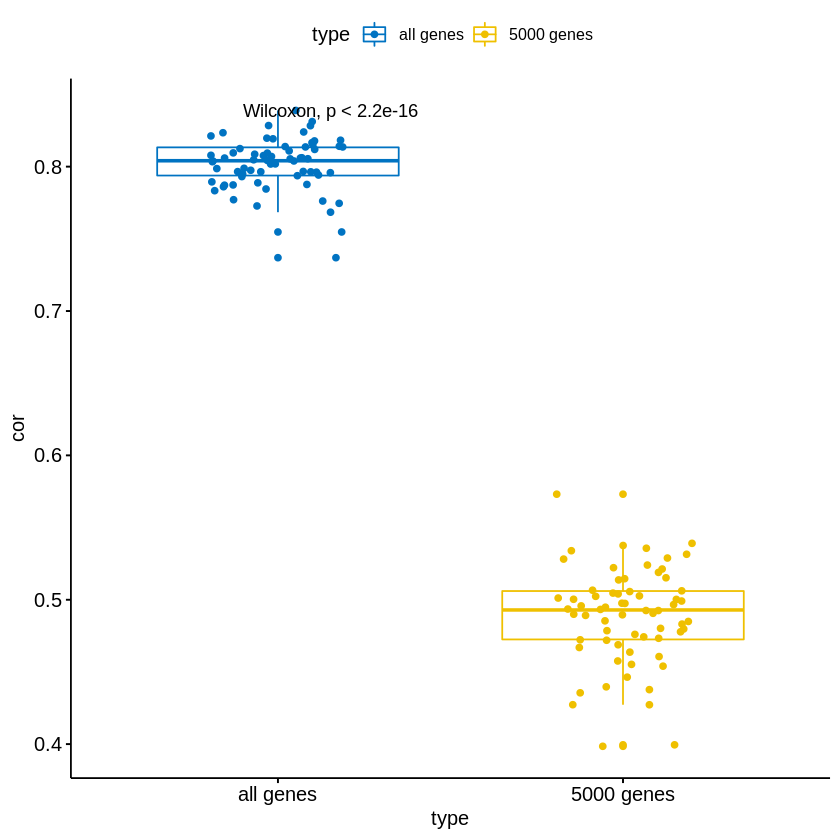

In [62]:
# library(ggpubr)
# p <- ggboxplot(ranks_bound, x = "type", y = "cor",
#           color = "type", palette = "jco",
#           add = "jitter")
# p + stat_compare_means()

In [58]:
# ranks[rownames(ranks2),]

cor       rank
ANBL6_DJ2_p13       0.8389621  1  
FLAM76_JCRB_p10     0.8212721  7  
ALMC1_DJ_p27        0.8312302  2  
MM1R_ATCC_p7        0.8284668  3  
JK6L_p5             0.8240218  5  
MOLP2_DSMZ_p18      0.8136530 16  
ALMC2_DJ_p11        0.8283566  4  
DP6_DJ_p7           0.8183032 10  
MM1S_ATCC_p7        0.8197308  8  
Karpas25_ECACC_p8   0.8165911 12  
KP6_DJ_p8           0.8178281 11  
INA6_p5             0.8151530 13  
OH2_PLB_p8          0.8076756 25  
KMS34_JCRB_p10      0.8192958  9  
KAS61_DJ_p5         0.8234968  6  
NCIH929_DSMZ_p8     0.8141154 14  
EJM_DSMZ_p9         0.8095510 21  
OCIMY7_p8           0.8053936 31  
Karpas929_ECACC_p10 0.7974868 41  
PCM6_Riken_p6       0.8093786 22  
Karpas929_ECACC_p15 0.7961785 46  
OCIMY1_p6           0.8086214 23  
Karpas417_ECACC_p12 0.7986617 40  
XG6_p5              0.8039465 34  
AMO1_DSMZ_p8        0.8038941 35  
VP6_DJ_p5           0.8042733 33  
JMW1_PLB_p6         0.8119339 19  
XG1_p5              0.8034119 36  
KMS18_p12           0.8078648 24  
H1112_p5            0.8059584 28  
⋮                   ⋮         ⋮   
JJN3_DSMZ_p8        0.8018963 37  
KMS12PE_JCRB_p9     0.8018169 38  
PE2_PLB_p9          0.8109006 20  
KMS26_JCRB_p9       0.8059498 29  
OCIMY5_p10          0.7966817 42  
XG2_p5              0.7964629 44  
JIM3_ECACC_p10      0.7949108 48  
KMS12BM_JCRB_p9     0.7941967 49  
KMS28BM_JCRB_p9     0.8070383 26  
KMS28PE_JCRB_p9     0.8047545 32  
XG7_p6              0.7988556 39  
LP1_DSMZ_p9         0.8054965 30  
RPMI8226_ATCC_p7    0.7894650 52  
KMS21BM_JCRB_p10    0.7860726 57  
U266_ATCC_p8        0.7873373 55  
KHM1B_JCRB_p12      0.7845235 58  
COLO677_DSMZ_p8     0.7887957 53  
KMS11_JCRB_Sus_p12  0.7965615 43  
KMS11_JCRB_Adh_p9   0.7931012 51  
MOLP8_DSMZ_p9       0.7876707 54  
Delta47_JCRB_p16    0.7770883 60  
OPM2_DSMZ_p9        0.7937400 50  
JIM1_ECACC_p11      0.7833494 59  
UTMC2_p6            0.7871660 56  
SKMM1_p6            0.7761831 61  
KHM11_p7            0.7745996 62  
KMM1_JCRB_p13       0.7684461 64  
OPM1_p7             0.7727705 63  
MMM1_p5             0.7369367 66  
FR4_p6              0.7547540 65

In [4]:
# testranks = c(1,2,3)
# testnames = c('a','b','c')
# names(testranks) = testnames
# testranks

# test2 = c('c','b','a')
# testranks[test2]

a b c 
1 2 3

c b a 
3 2 1